# Customer Service Chatbot Application

In [1]:
!pip install gradio --q
!pip install typing_extensions --q

In [2]:
!spacy download da_core_news_md --q

✔ Download and installation successful
You can now load the package via spacy.load('da_core_news_md')


## Import liberaries and conversation file

In [3]:
import pandas as pd  # Data manipulation and analysis library
import numpy as np  # Numerical computing library
import matplotlib.pyplot as plt  # Plotting library
import seaborn as sns  # Data visualization library based on matplotlib
import gradio as gr  # UI toolkit for creating interactive web interfaces

# Utils for various functionalities
import json  # JSON encoding and decoding
import requests  # HTTP library for making requests
import random  # Random number generation
import time  # Time-related functions
from collections import Counter  # Data structure for counting hashable objects

# spaCy library for NLP
import spacy  # NLP library for language preprocessing
nlp = spacy.load('da_core_news_md')  # Loading Danish language module

# Modelling
from sklearn.model_selection import train_test_split  # Splitting data into train and test sets
from imblearn.pipeline import Pipeline, make_pipeline  # Pipeline creation for data processing
from sklearn.feature_extraction.text import TfidfVectorizer  # Text to sparse matrix transformation
from sklearn.linear_model import LogisticRegression  # Logistic Regression model

# Machine Learning models
from sklearn.ensemble import RandomForestClassifier  # Random Forest Classifier
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors Classifier
from nltk.classify.scikitlearn import SklearnClassifier  # NLTK's SklearnClassifier wrapper
from sklearn.naive_bayes import MultinomialNB  # Multinomial Naive Bayes Classifier
from sklearn import svm  # Support Vector Machines Classifier
from sklearn.svm import SVC  # Support Vector Classifier
from xgboost.sklearn import XGBClassifier  # XGBoost Classifier
from sklearn.tree import DecisionTreeClassifier  # Decision Tree Classifier

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV  # Grid Search for hyperparameter tuning

# Evaluation metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Confusion Matrix visualization
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # Classification report and accuracy score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# For controlling warnings in the code
import warnings
from sklearn.exceptions import ConvergenceWarning  # Warning related to convergence during model fitting

/Users/tobiasmjensen/anaconda3/envs/bds-chatbot/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# We will call the below code to ignore all selected warnings in the code for getting more clearn outputs
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [5]:
# stream file from remote online (original/manual FAQ data)
original_data = requests.get('https://raw.githubusercontent.com/tobiasmj97/M3_Semester_Project/main/data/convo_snt_chatbot.json')
original_json_data = json.loads(original_data.text)

In [6]:
# stream file from remote online (synthetic data from chatGPT 4)
synthetic_data = requests.get('https://raw.githubusercontent.com/tobiasmj97/M3_Semester_Project/main/data/revised_synthetic_data.json')
synthetic_json_data = json.loads(synthetic_data.text)

# Data description and understanding

In [7]:
# Retrieving the first two elements from the 'intents' data within the original JSON data
original_json_data['intents'][:2]

[{'tag': 'hilsen',
  'patterns': ['Hej', 'Halløj', 'Goddag', 'God dag'],
  'responses': ['Hej 😊',
   'Hej, hvad kan jeg hjælpe med?',
   'Hej, hvordan kan jeg hjælpe?']},
 {'tag': 'svar',
  'patterns': ['Går det godt?'],
  'responses': ['Det går godt. Hvad med dig?']}]

In [8]:
# Reformating data and reformatting into useable data
original_data= []

for i in original_json_data['intents']:
  l = len(i['patterns'])
  tuples = list(zip(i['patterns'], l*[i['tag']]))
  original_data.extend(tuples)

In [9]:
# Created a pandas DataFrame from our original data
df_original = pd.DataFrame(original_data, columns=['txt','label'])
df_original.head()

,txt,label
0,Hej,hilsen
1,Halløj,hilsen
2,Goddag,hilsen
3,God dag,hilsen
4,Går det godt?,svar


In [10]:
df_original.shape

(167, 2)

In [11]:
# Reformating data and reformatting into useable data
synthetic_data = []

for i in synthetic_json_data['intents']:
  l = len(i['patterns'])
  tuples = list(zip(i['patterns'], l*[i['tag']]))
  synthetic_data.extend(tuples)

In [12]:
# Created a pandas DataFrame from our synthetic data
df_synthetic = pd.DataFrame(synthetic_data, columns=['txt','label'])
df_synthetic.head()

,txt,label
0,Hejsa,hilsen
1,Godmorgen,hilsen
2,Hej der,hilsen
3,Goddag til dig,hilsen
4,Alt vel?,svar


In [13]:
df_synthetic.shape

(98, 2)

# Merge data

In [14]:
# Concatenate along the rows (axis=0)
merged_df = pd.concat([df_original, df_synthetic], axis=0, ignore_index=True)

In [15]:
# Retrieving the dimensions (rows, columns)
merged_df.shape

(265, 2)

In [16]:
# Accessing the value in the 'label' column at index 170 in the DataFrame merged_df
merged_df['label'][170]

'hilsen'

# Exploratory data analysis / EDA

## Overview of data / Description of the data

In [17]:
# How many questions do we have?
df_original['txt'].count()

167

In [18]:
# Count number of unique labels
df_original["label"].nunique()   

46

In [19]:
# Value counts for each labels
df_original["label"].value_counts()[:10]

label
Sådan indtaster du din rabatkode eller dit gavekort    6
Bestilling i butik                                     5
reklamation                                            5
Refundering                                            5
moms                                                   5
hilsen                                                 4
Ordrenummer ved returnering                            4
Told- og importgebyr                                   4
Ombytning eller returnering af gave købt i butik       4
Returnering af produkter fra forskellige ordrer        4
Name: count, dtype: int64

In [20]:
# Statistics for the sentences
print("Minimum sentence length : ", df_original['txt'].str.len().min())
print("Maximum  sentence length : ", df_original['txt'].str.len().max())
print("Average sentence length : ", df_original['txt'].str.len().mean())
print("Median sentence length : ", df_original['txt'].str.len().median())
print("Mode : ", df_original['txt'].str.len().mode())

Minimum sentence length :  3
Maximum  sentence length :  65
Average sentence length :  32.32335329341317
Median sentence length :  31.0
Mode :  0    29
Name: txt, dtype: int64


## EDA on pattern attribute

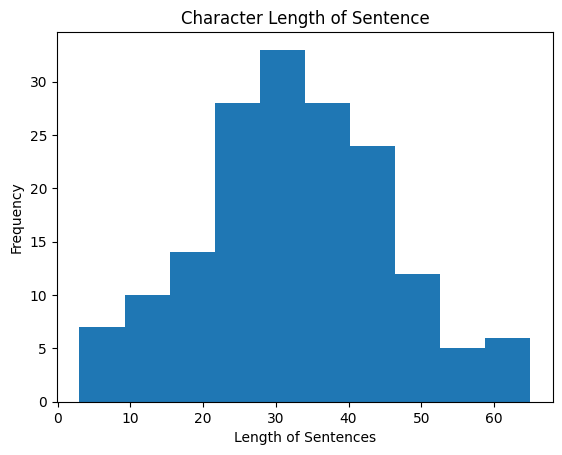

In [21]:
# Making a histogram for the question and the length of the question
df_original['txt'].str.len().hist()

# Adding axis titles
plt.xlabel('Length of Sentences')
plt.ylabel('Frequency')

# Adding plot title
plt.title('Character Length of Sentence')

# Display the plot
plt.grid(False)
plt.show()

In [22]:
text = df_original['txt']

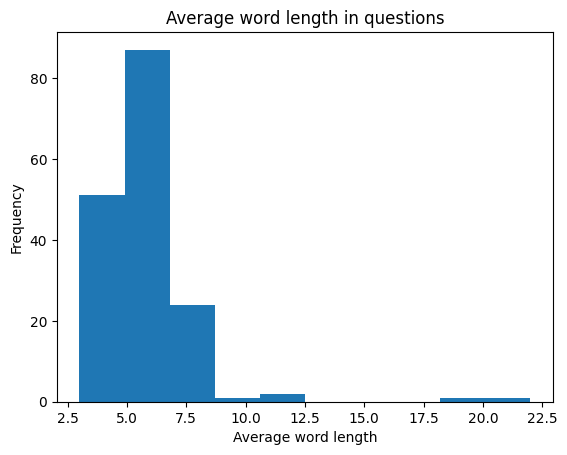

In [23]:
# making a function for average word length in each sentence
# average word length in each questions sentence

text.str.split().\
    apply(lambda x : [len(i) for i in x]). \
    map(lambda x: np.mean(x)).\
    hist()

# Adding axis titles
plt.xlabel('Average word length')
plt.ylabel('Frequency')

# Adding plot title
plt.title('Average word length in questions')

# Display the plot
plt.grid(False)
plt.show()

### Make additional attributes

In [24]:
# Length of questions
df_original['Length_txt'] = df_original['txt'].str.len()

In [25]:
# count of words for questions
def word_count(review):
    review_list = review.split()
    return len(review_list)

df_original['Word_count'] = df_original['txt'].apply(word_count)

In [26]:
# mean word length for each question
df_original['mean_word_length'] = df_original['txt'].map(lambda rev: np.mean([len(word) for word in rev.split()]))

In [27]:
def count_characters(sentence):
    return len(sentence)

# mean sentence length 
df_original['mean_sent_length'] = df_original['txt'].apply(lambda x: count_characters(x))

In [28]:
# show all the new attributes
df_original.head()

,txt,label,Length_txt,Word_count,mean_word_length,mean_sent_length
0,Hej,hilsen,3,1,3.000000,3
1,Halløj,hilsen,6,1,6.000000,6
2,Goddag,hilsen,6,1,6.000000,6
3,God dag,hilsen,7,2,3.000000,7
4,Går det godt?,svar,13,3,3.666667,13


In [29]:
# Statistics for the sentences
print("Minimum word count : ", df_original['Word_count'].min())
print("Maximum  word count : ", df_original['Word_count'].max())
print("Average word count : ", df_original['Word_count'].mean())
print("Median word count : ", df_original['Word_count'].median())
print("Mode : ", df_original['Word_count'].mode())

Minimum word count :  1
Maximum  word count :  12
Average word count :  5.2155688622754495
Median word count :  5.0
Mode :  0    5
Name: Word_count, dtype: int64


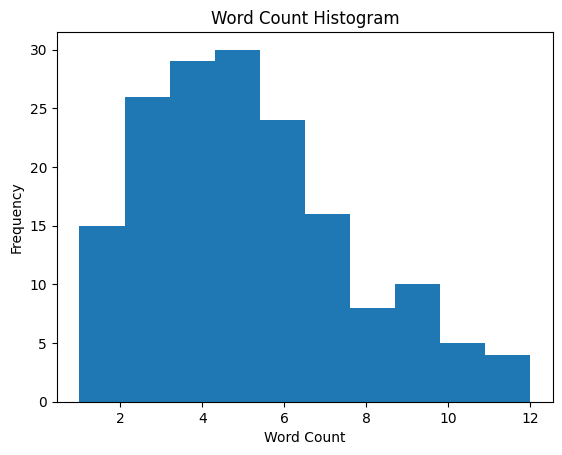

In [30]:
# make a historgram for word count
df_original['Word_count'].hist()

# Adding axis titles
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Adding plot title
plt.title('Word Count Histogram')

# Display the plot
plt.grid(False)
plt.show()

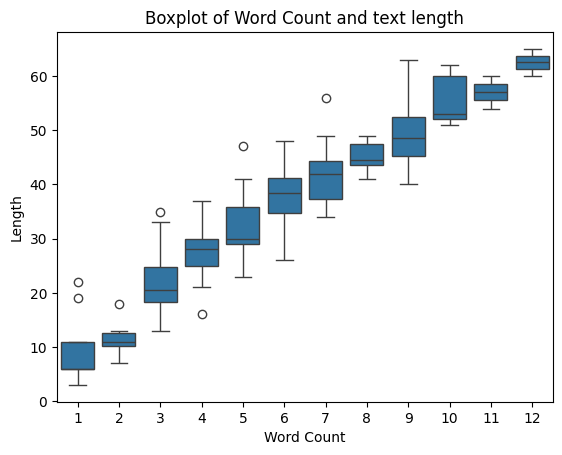

In [31]:
# box plot for word count and length of questions
sns.boxplot(data=df_original, x="Word_count", y="Length_txt")

# Adding axis titles
plt.xlabel('Word Count')
plt.ylabel('Length')

# Adding plot title
plt.title('Boxplot of Word Count and text length')

# Display the plot
plt.grid(False)
plt.show()


## EDA on stop words and most frequent words

In [32]:
# setting the text to df_original['txt']
text = df_original['txt']

# Creating a list of stopwords using spaCy's default stop words
stopwords = list(nlp.Defaults.stop_words)

<BarContainer object of 10 artists>

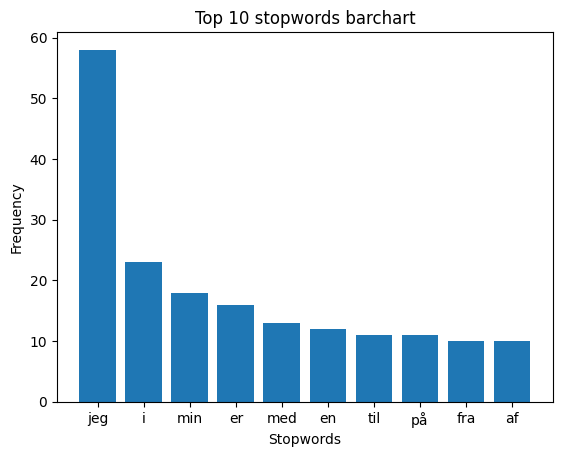

In [33]:
# Splitting the 'text' into words and creating a corpus (a flat list of all words)
new = text.str.split()
new = new.values.tolist()
corpus = [word for sublist in new for word in sublist]

# Counting the occurrences of stopwords in the corpus using a defaultdict
from collections import defaultdict
dic = defaultdict(int)
for word in corpus:
    if word in stopwords:
        dic[word] += 1

# Selecting the top 10 most frequent stopwords
top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]
x, y = zip(*top)

# Adding axis titles
plt.xlabel('Stopwords')
plt.ylabel('Frequency')

# Adding plot title
plt.title('Top 10 stopwords barchart')

# Display the plot
plt.grid(False)
plt.bar(x, y)

In [34]:
# Splitting the 'text' into words and creating a corpus (a flat list of all words)
new = text.str.split()  # Splitting the text into individual words
new = new.values.tolist()  # Converting the split words to a list
corpus = [word for sublist in new for word in sublist]  # Creating a flat list of words

from collections import defaultdict
# Initializing a dictionary to store word frequencies
dic = defaultdict(int)

# Counting the occurrences of words in the corpus that are present in the stopwords list
for word in corpus:
    if word in stopwords:
        dic[word] += 1

# Selecting the top 10 most frequent stopwords based on their counts
top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]

# display top 10 most frequent stopwords
top

[('jeg', 58),
 ('i', 23),
 ('min', 18),
 ('er', 16),
 ('med', 13),
 ('en', 12),
 ('til', 11),
 ('på', 11),
 ('fra', 10),
 ('af', 10)]

<Axes: title={'center': 'Top non-stopwords barchart'}, xlabel='Frequency', ylabel='Stopwords'>

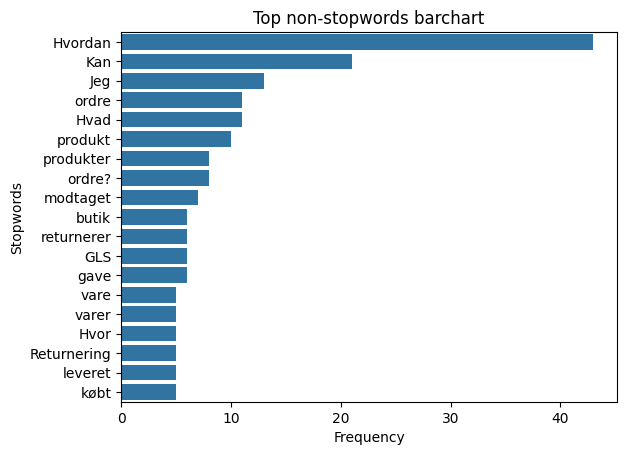

In [35]:
# Splitting the 'text' into words and creating a corpus (a flat list of all words)
new = text.str.split()  # Splitting the text into individual words
new = new.values.tolist()  # Converting the split words to a list
corpus = [word for sublist in new for word in sublist]  # Creating a flat list of words

# Counting the occurrences of each word in the corpus
counter = Counter(corpus)
most = counter.most_common()  # Extracting the most common words and their counts

x, y = [], []
# Extracting the top 40 most common non-stopwords for visualization
for word, count in most[:40]:
    if word not in stopwords:  # Checking if the word is not a stopword
        x.append(word)  # Storing the word
        y.append(count)  # Storing its count

# Adding axis titles
plt.xlabel('Frequency')
plt.ylabel('Stopwords')

# Adding plot title
plt.title('Top non-stopwords barchart')

# Display the plot
plt.grid(False)
sns.barplot(x=y, y=x)

In [36]:
# Splitting the 'text' into words and creating a corpus (a flat list of all words)
new = text.str.split()  # Splitting the text into individual words
new = new.values.tolist()  # Converting the split words to a list
corpus = [word for sublist in new for word in sublist]  # Creating a flat list of words

# Counting the occurrences of each word in the corpus
counter = Counter(corpus)
most = counter.most_common()  # Extracting the most common words and their counts

# Selecting the top 10 most common non-stopwords
top_non_stopwords = [(word, count) for word, count in most if word not in stopwords][:10]

# display top 10 most common non-stopwords
top_non_stopwords

[('Hvordan', 43),
 ('Kan', 21),
 ('Jeg', 13),
 ('ordre', 11),
 ('Hvad', 11),
 ('produkt', 10),
 ('produkter', 8),
 ('ordre?', 8),
 ('modtaget', 7),
 ('butik', 6)]

# Data cleaning and preparation

## Text Preprocessing

In [37]:
def text_prepro(texts):
    """
    Takes in a list/iterable of texts
    Lowercases and normalizes text
    """

    clean_container = []  # Container to store cleaned texts

    # Loop through each text in the list/iterable
    for text in nlp.pipe(texts, disable=["parser", "ner"]):  # Using spaCy for text processing

        # Extracting lemmatized lowercase tokens without numbers or punctuation
        txt = [token.lemma_.lower() for token in text
               if token.is_alpha  # Remove numbers
               and not token.is_punct]  # Remove punctuation

        clean_container.append(" ".join(txt))  # Joining the cleaned tokens back into text

    return clean_container  # Returning the cleaned texts in a list

In [38]:
# Using spaCy's NLP pipeline to process the text at index 15 in the 'txt' column of the DataFrame
# Extracting the vector representation and retrieving its shape
nlp(df_original['txt'][15]).vector.shape

(300,)

In [39]:
# Accessing the text data at index 15 in the 'txt' column of the DataFrame df_original
df_original['txt'][15]

'Hvordan bestiller jeg produkter fra butikken?'

# Model building

In [40]:
# Applying text preprocessing function to create a new column 'txt_p' in the original and synthetic dataframes
df_original['txt_p'] = text_prepro(df_original['txt'])
df_synthetic['txt_p'] = text_prepro(df_synthetic['txt'])

In [41]:
df_original.head()

,txt,label,Length_txt,Word_count,mean_word_length,mean_sent_length,txt_p
0,Hej,hilsen,3,1,3.000000,3,hej
1,Halløj,hilsen,6,1,6.000000,6,halløj
2,Goddag,hilsen,6,1,6.000000,6,goddag
3,God dag,hilsen,7,2,3.000000,7,god dag
4,Går det godt?,svar,13,3,3.666667,13,gå det godt


In [42]:
df_synthetic.head()

,txt,label,txt_p
0,Hejsa,hilsen,hejsa
1,Godmorgen,hilsen,godmorgen
2,Hej der,hilsen,hej der
3,Goddag til dig,hilsen,goddag til du
4,Alt vel?,svar,al vel


In [43]:
# Splitting the data into training and test sets for modeling
# Features (X) are the preprocessed text ('txt_p'), labels (y) are from the 'label' column
# Using 80% of the data for training and 20% for testing, and setting a random seed for reproducibility
X = df_original['txt_p']
y = df_original['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Merged data split

In [44]:
# Applying text preprocessing function to create a new column 'txt_p' in the merged dataframe
merged_df['txt_p'] = text_prepro(merged_df['txt'])

In [45]:
merged_df.head()

,txt,label,txt_p
0,Hej,hilsen,hej
1,Halløj,hilsen,halløj
2,Goddag,hilsen,goddag
3,God dag,hilsen,god dag
4,Går det godt?,svar,gå det godt


In [46]:
# Splitting the merged data into training and test sets for modeling
# Features (X_merged) are the preprocessed text ('txt_p'), labels (y_merged) are from the 'label' column
# Using 80% of the data for training and 20% for testing, and setting a random seed for reproducibility
X_merged = merged_df['txt_p']
y_merged = merged_df['label']
X_train_merged, X_test_merged, y_train_merged, y_test_merged = train_test_split(X_merged, y_merged, test_size=0.2, random_state=42)

## Synthetic data

In [47]:
# Creating validation data for synthetic data
# Features (X_val) are the preprocessed text ('txt_p') from the synthetic dataframe
# Labels (y_val) are from the 'label' column in the synthetic dataframe
X_val = df_synthetic['txt_p']
y_val = df_synthetic['label']

# Model training

## Word2Vec Models (W2V)

In [48]:
# Generating word vectors for the texts in the training and test sets separately and stacking them into matrices
# Looping through each text in X_train, processing them through spaCy's pipeline to get word vectors,
# and stacking these vectors into a matrix

# For the original data
X_train_W2V = np.vstack([txt.vector for txt in nlp.pipe(X_train, disable=["parser", "ner"])])  # Word vectors for training set
X_test_W2V = np.vstack([txt.vector for txt in nlp.pipe(X_test, disable=["parser", "ner"])])  # Word vectors for test set

# For the merged data
X_train_merged_W2V = np.vstack([txt.vector for txt in nlp.pipe(X_train_merged, disable=["parser", "ner"])])  # Word vectors for training set of merged data
X_test_merged_W2V = np.vstack([txt.vector for txt in nlp.pipe(X_test_merged, disable=["parser", "ner"])])  # Word vectors for test set of merged data

### W2V + Multinomial LogisticRegression

### TF-IDF + LogisticRegression

In [49]:
# Creating a Logistic Regression model for multi-class classification
model_w2v_lr = LogisticRegression(multi_class='multinomial')
model_w2v_lr_merged = LogisticRegression(multi_class='multinomial')

In [50]:
# Fitting the Logistic Regression model on the training data with word vectors
model_w2v_lr.fit(X_train_W2V, y_train)

# Fitting the merged Logistic Regression model on the training data with word vectors
model_w2v_lr_merged.fit(X_train_merged_W2V, y_train_merged)

LogisticRegression(multi_class='multinomial')

In [51]:
# Predicting labels for the training set using the trained Logistic Regression model
y_pred_train = model_w2v_lr.predict(X_train_W2V)

# Predicting labels for the test set using the trained Logistic Regression model
y_pred_test = model_w2v_lr.predict(X_test_W2V)

# Predicting labels for the merged training set using the trained Logistic Regression model
y_pred_train_merged = model_w2v_lr_merged.predict(X_train_merged_W2V)

# Predicting labels for the merged test set using the trained Logistic Regression model
y_pred_test_merged = model_w2v_lr_merged.predict(X_test_merged_W2V)

In [52]:
# Printing the classification report for predictions on the original training set
print("classification_report train original")
print(classification_report(y_train, y_pred_train))

classification_report train original
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       1.00      1.00      1.00         4
                                        Annullering af ordre       1.00      1.00      1.00         4
                                          Bestilling i butik       1.00      1.00      1.00         2
                                         Betaling med Klarna       1.00      1.00      1.00         4
                                         Betalingsmuligheder       1.00      1.00      1.00         2
                                     Defekt produkt modtaget       1.00      1.00      1.00         4
                                                     Erhverv       1.00      1.00      1.00         3
                                    Forkert produkt modtaget       1.00      1.00      1.00         4
                                            

In [53]:
# Printing the classification report for predictions on the original test set
print("classification_report test original")
print(classification_report(y_test, y_pred_test))

classification_report test original
                                                              precision    recall  f1-score   support

                                        Annullering af ordre       0.00      0.00      0.00         0
                                          Bestilling i butik       1.00      0.67      0.80         3
                                         Betaling med Klarna       0.00      0.00      0.00         0
                                         Betalingsmuligheder       0.00      0.00      0.00         1
                                     Defekt produkt modtaget       0.00      0.00      0.00         0
                                                     Erhverv       0.50      1.00      0.67         1
                                                    Gavekort       0.00      0.00      0.00         1
Kan jeg få besked, når en udsolgt vare kommer på lager igen?       1.00      1.00      1.00         1
                                        Lever

In [54]:
# Printing the classification report for predictions on the merged training set
print("classification_report train merged")
print(classification_report(y_train_merged, y_pred_train_merged))

classification_report train merged
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       1.00      0.86      0.92         7
                                        Annullering af ordre       1.00      1.00      1.00         7
                                          Bestilling i butik       1.00      1.00      1.00         7
                                         Betaling med Klarna       1.00      1.00      1.00         3
                                         Betalingsmuligheder       1.00      1.00      1.00         3
                                     Defekt produkt modtaget       1.00      1.00      1.00         7
                                                     Erhverv       1.00      1.00      1.00         4
                                    Forkert produkt modtaget       1.00      1.00      1.00         8
                                              

In [55]:
# Printing the classification report for predictions on the merged test set
print("classification_report test merged")
print(classification_report(y_test_merged, y_pred_test_merged))

classification_report test merged
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       0.00      0.00      0.00         1
                                        Annullering af ordre       1.00      1.00      1.00         1
                                          Bestilling i butik       0.50      0.33      0.40         3
                                         Betaling med Klarna       1.00      1.00      1.00         1
                                     Defekt produkt modtaget       1.00      1.00      1.00         1
                                                     Erhverv       0.00      0.00      0.00         0
                                                    Gavekort       0.00      0.00      0.00         0
                       Hvornår modtager jeg min refundering?       0.67      0.67      0.67         3
Kan jeg få besked, når en udsolgt vare kommer p

In [56]:
# Calculating and printing the accuracy score for the original training set
print('Accuracy Score for for train: %.5f'%accuracy_score(y_train, y_pred_train))

# Calculating and printing the accuracy score for the original test set
print('Accuracy Score for for test: %.5f'%accuracy_score(y_test, y_pred_test))

# Calculating and printing the accuracy score for the merged training set
print('Accuracy Score for train merged: %.5f'%accuracy_score(y_train_merged, y_pred_train_merged))

# Calculating and printing the accuracy score for the merged test set
print('Accuracy Score for test merged: %.5f'%accuracy_score(y_test_merged, y_pred_test_merged))

# Calculating and printing the precision score for the original training set
print('Precision Score for for train: %.5f'%precision_score(y_train, y_pred_train, average='weighted'))

# Calculating and printing the precision score for the original test set
print('Precision Score for for test: %.5f'%precision_score(y_test, y_pred_test, average='weighted'))

# Calculating and printing the precision score for the merged training set
print('Precision Score for train merged: %.5f'%precision_score(y_train_merged, y_pred_train_merged, average='weighted'))

# Calculating and printing the precision score for the merged test set
print('Precision Score for test merged: %.5f'%precision_score(y_test_merged, y_pred_test_merged, average='weighted'))

# Calculating and printing the recall score for the original training set
print('Recall Score for for train: %.5f'%recall_score(y_train, y_pred_train, average='weighted'))

# Calculating and printing the recall score for the original test set
print('Recall Score for for test: %.5f'%recall_score(y_test, y_pred_test, average='weighted'))

# Calculating and printing the recall score for the merged training set
print('Recall Score for train merged: %.5f'%recall_score(y_train_merged, y_pred_train_merged, average='weighted'))

# Calculating and printing the recall score for the merged test set
print('Recall Score for test merged: %.5f'%recall_score(y_test_merged, y_pred_test_merged, average='weighted'))

# Calculating and printing the f1 score for the original training set
print('F1 Score for for train: %.5f'%f1_score(y_train, y_pred_train, average='weighted'))

# Calculating and printing the f1 score for the original test set
print('F1 Score for for test: %.5f'%f1_score(y_test, y_pred_test, average='weighted'))

# Calculating and printing the f1 score for the merged training set
print('F1 Score for train merged: %.5f'%f1_score(y_train_merged, y_pred_train_merged, average='weighted'))

# Calculating and printing the f1 score for the merged test set
print('F1 Score for test merged: %.5f'%f1_score(y_test_merged, y_pred_test_merged, average='weighted'))

Accuracy Score for for train: 0.98496
Accuracy Score for for test: 0.41176
Accuracy Score for train merged: 0.98113
Accuracy Score for test merged: 0.66038
Precision Score for for train: 0.98835
Precision Score for for test: 0.45588
Precision Score for train merged: 0.98571
Precision Score for test merged: 0.69340
Recall Score for for train: 0.98496
Recall Score for for test: 0.41176
Recall Score for train merged: 0.98113
Recall Score for test merged: 0.66038
F1 Score for for train: 0.98463
F1 Score for for test: 0.40392
F1 Score for train merged: 0.98150
F1 Score for test merged: 0.65912


In [57]:
model_w2v_lr_scores = {
    'Train Accuracy (Original)': accuracy_score(y_train, y_pred_train),
    'Test Accuracy (Original)': accuracy_score(y_test, y_pred_test),
    'Train Accuracy (Merged)': accuracy_score(y_train_merged, y_pred_train_merged),
    'Test Accuracy (Merged)': accuracy_score(y_test_merged, y_pred_test_merged),

    'Train Precision (Original)': precision_score(y_train, y_pred_train, average='weighted'),
    'Test Precision (Original)': precision_score(y_test, y_pred_test, average='weighted'),
    'Train Precision (Merged)': precision_score(y_train_merged, y_pred_train_merged, average='weighted'),
    'Test Precision (Merged)': precision_score(y_test_merged, y_pred_test_merged, average='weighted'),

    'Train Recall (Original)': recall_score(y_train, y_pred_train, average='weighted'),
    'Test Recall (Original)': recall_score(y_test, y_pred_test, average='weighted'),
    'Train Recall (Merged)': recall_score(y_train_merged, y_pred_train_merged, average='weighted'),
    'Test Recall (Merged)': recall_score(y_test_merged, y_pred_test_merged, average='weighted'),

    'Train F1 Score (Original)': f1_score(y_train, y_pred_train, average='weighted'),
    'Test F1 Score (Original)': f1_score(y_test, y_pred_test, average='weighted'),
    'Train F1 Score (Merged)': f1_score(y_train_merged, y_pred_train_merged, average='weighted'),
    'Test F1 Score (Merged)': f1_score(y_test_merged, y_pred_test_merged, average='weighted')
}

### W2V + Support Vector Machine (SVM)

In [58]:
# Creating a Support Vector Machine (SVM) model for classification
model_w2v_svm = svm.SVC()
model_w2v_svm_merged = svm.SVC()

In [59]:
# Fitting the SVM model using the word vector features and training labels
model_w2v_svm.fit(X_train_W2V, y_train)

# Fitting the merged SVM model using the word vector features and training labels
model_w2v_svm_merged.fit(X_train_merged_W2V, y_train_merged)

SVC()

In [60]:
# Predicting labels for the training set using the trained SVM model
y_pred_train = model_w2v_svm.predict(X_train_W2V)

# Predicting labels for the test set using the trained SVM model
y_pred_test = model_w2v_svm.predict(X_test_W2V)

# Predicting labels for the merged training set using the trained SVM model
y_pred_train_merged = model_w2v_svm_merged.predict(X_train_merged_W2V)

# Predicting labels for the merged test set using the trained SVM model
y_pred_test_merged = model_w2v_svm_merged.predict(X_test_merged_W2V)

In [61]:
# Printing the classification report for predictions on the original training set
print("classification_report train original")
print(classification_report(y_train, y_pred_train))

classification_report train original
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       0.40      1.00      0.57         4
                                        Annullering af ordre       0.00      0.00      0.00         4
                                          Bestilling i butik       0.00      0.00      0.00         2
                                         Betaling med Klarna       0.80      1.00      0.89         4
                                         Betalingsmuligheder       0.00      0.00      0.00         2
                                     Defekt produkt modtaget       1.00      0.50      0.67         4
                                                     Erhverv       1.00      1.00      1.00         3
                                    Forkert produkt modtaget       0.67      1.00      0.80         4
                                            

In [62]:
# Printing the classification report for predictions on the original test set
print("classification_report test original")
print(classification_report(y_test, y_pred_test))

classification_report test original
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       0.00      0.00      0.00         0
                                          Bestilling i butik       0.00      0.00      0.00         3
                                         Betaling med Klarna       0.00      0.00      0.00         0
                                         Betalingsmuligheder       0.00      0.00      0.00         1
                                                     Erhverv       1.00      1.00      1.00         1
                                                    Gavekort       0.00      0.00      0.00         1
                       Hvornår modtager jeg min refundering?       0.00      0.00      0.00         0
Kan jeg få besked, når en udsolgt vare kommer på lager igen?       0.00      0.00      0.00         1
                                        Lever

In [63]:
# Printing the classification report for predictions on the merged training set
print("classification_report train merged")
print(classification_report(y_train_merged, y_pred_train_merged))

classification_report train merged
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       0.40      0.86      0.55         7
                                        Annullering af ordre       0.62      0.71      0.67         7
                                          Bestilling i butik       0.54      1.00      0.70         7
                                         Betaling med Klarna       1.00      0.33      0.50         3
                                         Betalingsmuligheder       0.00      0.00      0.00         3
                                     Defekt produkt modtaget       0.21      0.43      0.29         7
                                                     Erhverv       1.00      1.00      1.00         4
                                    Forkert produkt modtaget       0.47      1.00      0.64         8
                                              

In [64]:
# Printing the classification report for predictions on the merged test set
print("classification_report test merged")
print(classification_report(y_test_merged, y_pred_test_merged))

classification_report test merged
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       0.14      1.00      0.25         1
                                        Annullering af ordre       0.00      0.00      0.00         1
                                          Bestilling i butik       0.50      0.33      0.40         3
                                         Betaling med Klarna       0.00      0.00      0.00         1
                                     Defekt produkt modtaget       0.25      1.00      0.40         1
                                    Forkert produkt modtaget       0.00      0.00      0.00         0
                       Hvornår modtager jeg min refundering?       0.00      0.00      0.00         3
Kan jeg få besked, når en udsolgt vare kommer på lager igen?       0.00      0.00      0.00         1
                                        Leverin

In [65]:
# Calculating and printing the accuracy score for the original training set
print('Accuracy Score for for train: %.5f'%accuracy_score(y_train, y_pred_train))

# Calculating and printing the accuracy score for the original test set
print('Accuracy Score for for test: %.5f'%accuracy_score(y_test, y_pred_test))

# Calculating and printing the accuracy score for the merged training set
print('Accuracy Score for train merged: %.5f'%accuracy_score(y_train_merged, y_pred_train_merged))

# Calculating and printing the accuracy score for the merged test set
print('Accuracy Score for test merged: %.5f'%accuracy_score(y_test_merged, y_pred_test_merged))

# Calculating and printing the precision score for the original training set
print('Precision Score for for train: %.5f'%precision_score(y_train, y_pred_train, average='weighted'))

# Calculating and printing the precision score for the original test set
print('Precision Score for for test: %.5f'%precision_score(y_test, y_pred_test, average='weighted'))

# Calculating and printing the precision score for the merged training set
print('Precision Score for train merged: %.5f'%precision_score(y_train_merged, y_pred_train_merged, average='weighted'))

# Calculating and printing the precision score for the merged test set
print('Precision Score for test merged: %.5f'%precision_score(y_test_merged, y_pred_test_merged, average='weighted'))

# Calculating and printing the recall score for the original training set
print('Recall Score for for train: %.5f'%recall_score(y_train, y_pred_train, average='weighted'))

# Calculating and printing the recall score for the original test set
print('Recall Score for for test: %.5f'%recall_score(y_test, y_pred_test, average='weighted'))

# Calculating and printing the recall score for the merged training set
print('Recall Score for train merged: %.5f'%recall_score(y_train_merged, y_pred_train_merged, average='weighted'))

# Calculating and printing the recall score for the merged test set
print('Recall Score for test merged: %.5f'%recall_score(y_test_merged, y_pred_test_merged, average='weighted'))

# Calculating and printing the f1 score for the original training set
print('F1 Score for for train: %.5f'%f1_score(y_train, y_pred_train, average='weighted'))

# Calculating and printing the f1 score for the original test set
print('F1 Score for for test: %.5f'%f1_score(y_test, y_pred_test, average='weighted'))

# Calculating and printing the f1 score for the merged training set
print('F1 Score for train merged: %.5f'%f1_score(y_train_merged, y_pred_train_merged, average='weighted'))

# Calculating and printing the f1 score for the merged test set
print('F1 Score for test merged: %.5f'%f1_score(y_test_merged, y_pred_test_merged, average='weighted'))

Accuracy Score for for train: 0.57895
Accuracy Score for for test: 0.08824
Accuracy Score for train merged: 0.60849
Accuracy Score for test merged: 0.20755
Precision Score for for train: 0.48812
Precision Score for for test: 0.11765
Precision Score for train merged: 0.56842
Precision Score for test merged: 0.20508
Recall Score for for train: 0.57895
Recall Score for for test: 0.08824
Recall Score for train merged: 0.60849
Recall Score for test merged: 0.20755
F1 Score for for train: 0.49154
F1 Score for for test: 0.09804
F1 Score for train merged: 0.53783
F1 Score for test merged: 0.17143


In [66]:
model_w2v_svm_scores = {
    'Train Accuracy (Original)': accuracy_score(y_train, y_pred_train),
    'Test Accuracy (Original)': accuracy_score(y_test, y_pred_test),
    'Train Accuracy (Merged)': accuracy_score(y_train_merged, y_pred_train_merged),
    'Test Accuracy (Merged)': accuracy_score(y_test_merged, y_pred_test_merged),

    'Train Precision (Original)': precision_score(y_train, y_pred_train, average='weighted'),
    'Test Precision (Original)': precision_score(y_test, y_pred_test, average='weighted'),
    'Train Precision (Merged)': precision_score(y_train_merged, y_pred_train_merged, average='weighted'),
    'Test Precision (Merged)': precision_score(y_test_merged, y_pred_test_merged, average='weighted'),

    'Train Recall (Original)': recall_score(y_train, y_pred_train, average='weighted'),
    'Test Recall (Original)': recall_score(y_test, y_pred_test, average='weighted'),
    'Train Recall (Merged)': recall_score(y_train_merged, y_pred_train_merged, average='weighted'),
    'Test Recall (Merged)': recall_score(y_test_merged, y_pred_test_merged, average='weighted'),

    'Train F1 Score (Original)': f1_score(y_train, y_pred_train, average='weighted'),
    'Test F1 Score (Original)': f1_score(y_test, y_pred_test, average='weighted'),
    'Train F1 Score (Merged)': f1_score(y_train_merged, y_pred_train_merged, average='weighted'),
    'Test F1 Score (Merged)': f1_score(y_test_merged, y_pred_test_merged, average='weighted')
}

### W2V + W2V + K-Nearest Neighbors (KNN)

In [67]:
# Creating a K-Nearest Neighbors (KNN) model for classification
model_w2v_knn = KNeighborsClassifier()
model_w2v_knn_merged = KNeighborsClassifier()

In [68]:
# Fitting the K-Nearest Neighbors (KNN) model using the word vector features and training labels
model_w2v_knn.fit(X_train_W2V, y_train)

# Fitting the merged K-Nearest Neighbors (KNN) model using the word vector features and training labels
model_w2v_knn_merged.fit(X_train_merged_W2V, y_train_merged)

KNeighborsClassifier()

In [69]:
# Predicting labels for the training set using the trained KNN model
y_pred_train = model_w2v_knn.predict(X_train_W2V)

# Predicting labels for the test set using the trained KNN model
y_pred_test = model_w2v_knn.predict(X_test_W2V)

# Predicting labels for the merged training set using the trained KNN model
y_pred_train_merged = model_w2v_knn_merged.predict(X_train_merged_W2V)

# Predicting labels for the merged test set using the trained KNN model
y_pred_test_merged = model_w2v_knn_merged.predict(X_test_merged_W2V)

In [70]:
# Printing the classification report for predictions on the original training set
print("classification_report train original")
print(classification_report(y_train, y_pred_train))

classification_report train original
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       0.38      0.75      0.50         4
                                        Annullering af ordre       0.38      0.75      0.50         4
                                          Bestilling i butik       0.33      1.00      0.50         2
                                         Betaling med Klarna       0.50      0.50      0.50         4
                                         Betalingsmuligheder       0.00      0.00      0.00         2
                                     Defekt produkt modtaget       0.43      0.75      0.55         4
                                                     Erhverv       1.00      1.00      1.00         3
                                    Forkert produkt modtaget       0.36      1.00      0.53         4
                                            

In [71]:
# Printing the classification report for predictions on the original test set
print("classification_report test original")
print(classification_report(y_test, y_pred_test))

classification_report test original
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       0.00      0.00      0.00         0
                                        Annullering af ordre       0.00      0.00      0.00         0
                                          Bestilling i butik       0.67      0.67      0.67         3
                                         Betaling med Klarna       0.00      0.00      0.00         0
                                         Betalingsmuligheder       0.00      0.00      0.00         1
                                     Defekt produkt modtaget       0.00      0.00      0.00         0
                                                     Erhverv       0.50      1.00      0.67         1
                                    Forkert produkt modtaget       0.00      0.00      0.00         0
                                             

In [72]:
# Printing the classification report for predictions on the merged training set
print("classification_report train merged")
print(classification_report(y_train_merged, y_pred_train_merged))

classification_report train merged
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       0.30      1.00      0.47         7
                                        Annullering af ordre       0.36      0.57      0.44         7
                                          Bestilling i butik       0.33      0.86      0.48         7
                                         Betaling med Klarna       0.25      0.33      0.29         3
                                         Betalingsmuligheder       0.00      0.00      0.00         3
                                     Defekt produkt modtaget       0.31      0.57      0.40         7
                                                     Erhverv       1.00      1.00      1.00         4
                                    Forkert produkt modtaget       0.39      0.88      0.54         8
                                              

In [73]:
# Printing the classification report for predictions on the merged test set
print("classification_report test merged")
print(classification_report(y_test_merged, y_pred_test_merged))

classification_report test merged
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       0.00      0.00      0.00         1
                                        Annullering af ordre       0.33      1.00      0.50         1
                                          Bestilling i butik       0.29      0.67      0.40         3
                                         Betaling med Klarna       0.00      0.00      0.00         1
                                         Betalingsmuligheder       0.00      0.00      0.00         0
                                     Defekt produkt modtaget       0.50      1.00      0.67         1
                                                     Erhverv       0.00      0.00      0.00         0
                                    Forkert produkt modtaget       0.00      0.00      0.00         0
                                               

In [74]:
# Calculating and printing the accuracy score for the original training set
print('Accuracy Score for for train: %.5f'%accuracy_score(y_train, y_pred_train))

# Calculating and printing the accuracy score for the original test set
print('Accuracy Score for for test: %.5f'%accuracy_score(y_test, y_pred_test))

# Calculating and printing the accuracy score for the merged training set
print('Accuracy Score for train merged: %.5f'%accuracy_score(y_train_merged, y_pred_train_merged))

# Calculating and printing the accuracy score for the merged test set
print('Accuracy Score for test merged: %.5f'%accuracy_score(y_test_merged, y_pred_test_merged))

# Calculating and printing the precision score for the original training set
print('Precision Score for for train: %.5f'%precision_score(y_train, y_pred_train, average='weighted'))

# Calculating and printing the precision score for the original test set
print('Precision Score for for test: %.5f'%precision_score(y_test, y_pred_test, average='weighted'))

# Calculating and printing the precision score for the merged training set
print('Precision Score for train merged: %.5f'%precision_score(y_train_merged, y_pred_train_merged, average='weighted'))

# Calculating and printing the precision score for the merged test set
print('Precision Score for test merged: %.5f'%precision_score(y_test_merged, y_pred_test_merged, average='weighted'))

# Calculating and printing the recall score for the original training set
print('Recall Score for for train: %.5f'%recall_score(y_train, y_pred_train, average='weighted'))

# Calculating and printing the recall score for the original test set
print('Recall Score for for test: %.5f'%recall_score(y_test, y_pred_test, average='weighted'))

# Calculating and printing the recall score for the merged training set
print('Recall Score for train merged: %.5f'%recall_score(y_train_merged, y_pred_train_merged, average='weighted'))

# Calculating and printing the recall score for the merged test set
print('Recall Score for test merged: %.5f'%recall_score(y_test_merged, y_pred_test_merged, average='weighted'))

# Calculating and printing the f1 score for the original training set
print('F1 Score for for train: %.5f'%f1_score(y_train, y_pred_train, average='weighted'))

# Calculating and printing the f1 score for the original test set
print('F1 Score for for test: %.5f'%f1_score(y_test, y_pred_test, average='weighted'))

# Calculating and printing the f1 score for the merged training set
print('F1 Score for train merged: %.5f'%f1_score(y_train_merged, y_pred_train_merged, average='weighted'))

# Calculating and printing the f1 score for the merged test set
print('F1 Score for test merged: %.5f'%f1_score(y_test_merged, y_pred_test_merged, average='weighted'))

Accuracy Score for for train: 0.51128
Accuracy Score for for test: 0.20588
Accuracy Score for train merged: 0.51415
Accuracy Score for test merged: 0.30189
Precision Score for for train: 0.47954
Precision Score for for test: 0.22059
Precision Score for train merged: 0.52049
Precision Score for test merged: 0.23270
Recall Score for for train: 0.51128
Recall Score for for test: 0.20588
Recall Score for train merged: 0.51415
Recall Score for test merged: 0.30189
F1 Score for for train: 0.44678
F1 Score for for test: 0.20588
F1 Score for train merged: 0.47118
F1 Score for test merged: 0.24560


In [75]:
model_w2v_knn_scores = {
    'Train Accuracy (Original)': accuracy_score(y_train, y_pred_train),
    'Test Accuracy (Original)': accuracy_score(y_test, y_pred_test),
    'Train Accuracy (Merged)': accuracy_score(y_train_merged, y_pred_train_merged),
    'Test Accuracy (Merged)': accuracy_score(y_test_merged, y_pred_test_merged),

    'Train Precision (Original)': precision_score(y_train, y_pred_train, average='weighted'),
    'Test Precision (Original)': precision_score(y_test, y_pred_test, average='weighted'),
    'Train Precision (Merged)': precision_score(y_train_merged, y_pred_train_merged, average='weighted'),
    'Test Precision (Merged)': precision_score(y_test_merged, y_pred_test_merged, average='weighted'),

    'Train Recall (Original)': recall_score(y_train, y_pred_train, average='weighted'),
    'Test Recall (Original)': recall_score(y_test, y_pred_test, average='weighted'),
    'Train Recall (Merged)': recall_score(y_train_merged, y_pred_train_merged, average='weighted'),
    'Test Recall (Merged)': recall_score(y_test_merged, y_pred_test_merged, average='weighted'),

    'Train F1 Score (Original)': f1_score(y_train, y_pred_train, average='weighted'),
    'Test F1 Score (Original)': f1_score(y_test, y_pred_test, average='weighted'),
    'Train F1 Score (Merged)': f1_score(y_train_merged, y_pred_train_merged, average='weighted'),
    'Test F1 Score (Merged)': f1_score(y_test_merged, y_pred_test_merged, average='weighted')
}

### W2V + Random Forrest

In [76]:
# Creating a Random Forest model for classification
model_w2v_rf = RandomForestClassifier()
model_w2v_rf_merged = RandomForestClassifier()

In [77]:
# Fitting the Random Forest model using the word vector features and training labels
model_w2v_rf.fit(X_train_W2V, y_train)

# Fitting the merged Random Forest model using the word vector features and training labels
model_w2v_rf_merged.fit(X_train_merged_W2V, y_train_merged)

RandomForestClassifier()

In [78]:
# Predicting labels for the training set using the trained Random Forest model
y_pred_train = model_w2v_rf.predict(X_train_W2V)

# Predicting labels for the test set using the trained Random Forest model
y_pred_test = model_w2v_rf.predict(X_test_W2V)

# Predicting labels for the merged training set using the trained Random Forest model
y_pred_train_merged = model_w2v_rf_merged.predict(X_train_merged_W2V)

# Predicting labels for the merged test set using the trained Random Forest model
y_pred_test_merged = model_w2v_rf_merged.predict(X_test_merged_W2V)

In [79]:
# Printing the classification report for predictions on the original training set
print("classification_report train original")
print(classification_report(y_train, y_pred_train))

classification_report train original
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       1.00      1.00      1.00         4
                                        Annullering af ordre       1.00      1.00      1.00         4
                                          Bestilling i butik       1.00      1.00      1.00         2
                                         Betaling med Klarna       1.00      1.00      1.00         4
                                         Betalingsmuligheder       1.00      1.00      1.00         2
                                     Defekt produkt modtaget       1.00      1.00      1.00         4
                                                     Erhverv       1.00      1.00      1.00         3
                                    Forkert produkt modtaget       1.00      1.00      1.00         4
                                            

In [80]:
# Printing the classification report for predictions on the original test set
print("classification_report test original")
print(classification_report(y_test, y_pred_test))

classification_report test original
                                                              precision    recall  f1-score   support

                                        Annullering af ordre       0.00      0.00      0.00         0
                                          Bestilling i butik       1.00      0.33      0.50         3
                                         Betaling med Klarna       0.00      0.00      0.00         0
                                         Betalingsmuligheder       0.00      0.00      0.00         1
                                     Defekt produkt modtaget       0.00      0.00      0.00         0
                                                     Erhverv       1.00      1.00      1.00         1
                                                    Gavekort       0.00      0.00      0.00         1
       Hvor kan man købe produkter fra Shaping New Tomorrow?       0.00      0.00      0.00         0
                       Hvornår modtager jeg m

In [81]:
# Printing the classification report for predictions on the merged training set
print("classification_report train merged")
print(classification_report(y_train_merged, y_pred_train_merged))

classification_report train merged
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       1.00      0.86      0.92         7
                                        Annullering af ordre       1.00      1.00      1.00         7
                                          Bestilling i butik       1.00      1.00      1.00         7
                                         Betaling med Klarna       1.00      1.00      1.00         3
                                         Betalingsmuligheder       1.00      1.00      1.00         3
                                     Defekt produkt modtaget       1.00      1.00      1.00         7
                                                     Erhverv       1.00      1.00      1.00         4
                                    Forkert produkt modtaget       1.00      1.00      1.00         8
                                              

In [82]:
# Printing the classification report for predictions on the merged test set
print("classification_report test merged")
print(classification_report(y_test_merged, y_pred_test_merged))

classification_report test merged
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       0.00      0.00      0.00         1
                                        Annullering af ordre       0.50      1.00      0.67         1
                                          Bestilling i butik       1.00      0.33      0.50         3
                                         Betaling med Klarna       0.00      0.00      0.00         1
                                     Defekt produkt modtaget       1.00      1.00      1.00         1
                                                     Erhverv       0.00      0.00      0.00         0
                       Hvornår modtager jeg min refundering?       0.00      0.00      0.00         3
Kan jeg få besked, når en udsolgt vare kommer på lager igen?       0.50      1.00      0.67         1
                                        Leverin

In [83]:
# Calculating and printing the accuracy score for the original training set
print('Accuracy Score for for train: %.5f'%accuracy_score(y_train, y_pred_train))

# Calculating and printing the accuracy score for the original test set
print('Accuracy Score for for test: %.5f'%accuracy_score(y_test, y_pred_test))

# Calculating and printing the accuracy score for the merged training set
print('Accuracy Score for train merged: %.5f'%accuracy_score(y_train_merged, y_pred_train_merged))

# Calculating and printing the accuracy score for the merged test set
print('Accuracy Score for test merged: %.5f'%accuracy_score(y_test_merged, y_pred_test_merged))

# Calculating and printing the precision score for the original training set
print('Precision Score for for train: %.5f'%precision_score(y_train, y_pred_train, average='weighted'))

# Calculating and printing the precision score for the original test set
print('Precision Score for for test: %.5f'%precision_score(y_test, y_pred_test, average='weighted'))

# Calculating and printing the precision score for the merged training set
print('Precision Score for train merged: %.5f'%precision_score(y_train_merged, y_pred_train_merged, average='weighted'))

# Calculating and printing the precision score for the merged test set
print('Precision Score for test merged: %.5f'%precision_score(y_test_merged, y_pred_test_merged, average='weighted'))

# Calculating and printing the recall score for the original training set
print('Recall Score for for train: %.5f'%recall_score(y_train, y_pred_train, average='weighted'))

# Calculating and printing the recall score for the original test set
print('Recall Score for for test: %.5f'%recall_score(y_test, y_pred_test, average='weighted'))

# Calculating and printing the recall score for the merged training set
print('Recall Score for train merged: %.5f'%recall_score(y_train_merged, y_pred_train_merged, average='weighted'))

# Calculating and printing the recall score for the merged test set
print('Recall Score for test merged: %.5f'%recall_score(y_test_merged, y_pred_test_merged, average='weighted'))

# Calculating and printing the f1 score for the original training set
print('F1 Score for for train: %.5f'%f1_score(y_train, y_pred_train, average='weighted'))

# Calculating and printing the f1 score for the original test set
print('F1 Score for for test: %.5f'%f1_score(y_test, y_pred_test, average='weighted'))

# Calculating and printing the f1 score for the merged training set
print('F1 Score for train merged: %.5f'%f1_score(y_train_merged, y_pred_train_merged, average='weighted'))

# Calculating and printing the f1 score for the merged test set
print('F1 Score for test merged: %.5f'%f1_score(y_test_merged, y_pred_test_merged, average='weighted'))

Accuracy Score for for train: 0.98496
Accuracy Score for for test: 0.29412
Accuracy Score for train merged: 0.98113
Accuracy Score for test merged: 0.50943
Precision Score for for train: 0.98835
Precision Score for for test: 0.36275
Precision Score for train merged: 0.98571
Precision Score for test merged: 0.64403
Recall Score for for train: 0.98496
Recall Score for for test: 0.29412
Recall Score for train merged: 0.98113
Recall Score for test merged: 0.50943
F1 Score for for train: 0.98463
F1 Score for for test: 0.29706
F1 Score for train merged: 0.98150
F1 Score for test merged: 0.52408


In [84]:
model_w2v_rf_scores = {
    'Train Accuracy (Original)': accuracy_score(y_train, y_pred_train),
    'Test Accuracy (Original)': accuracy_score(y_test, y_pred_test),
    'Train Accuracy (Merged)': accuracy_score(y_train_merged, y_pred_train_merged),
    'Test Accuracy (Merged)': accuracy_score(y_test_merged, y_pred_test_merged),

    'Train Precision (Original)': precision_score(y_train, y_pred_train, average='weighted'),
    'Test Precision (Original)': precision_score(y_test, y_pred_test, average='weighted'),
    'Train Precision (Merged)': precision_score(y_train_merged, y_pred_train_merged, average='weighted'),
    'Test Precision (Merged)': precision_score(y_test_merged, y_pred_test_merged, average='weighted'),

    'Train Recall (Original)': recall_score(y_train, y_pred_train, average='weighted'),
    'Test Recall (Original)': recall_score(y_test, y_pred_test, average='weighted'),
    'Train Recall (Merged)': recall_score(y_train_merged, y_pred_train_merged, average='weighted'),
    'Test Recall (Merged)': recall_score(y_test_merged, y_pred_test_merged, average='weighted'),

    'Train F1 Score (Original)': f1_score(y_train, y_pred_train, average='weighted'),
    'Test F1 Score (Original)': f1_score(y_test, y_pred_test, average='weighted'),
    'Train F1 Score (Merged)': f1_score(y_train_merged, y_pred_train_merged, average='weighted'),
    'Test F1 Score (Merged)': f1_score(y_test_merged, y_pred_test_merged, average='weighted')
}

## TF-IDF Models

### TF-IDF + Multinomial LogisticRegression

In [85]:
# Creating a pipeline with TF-IDF vectorizer and Logistic Regression classifier
tfidf = TfidfVectorizer()  # Initializing TF-IDF vectorizer
lr = LogisticRegression(multi_class='multinomial')  # Initializing Logistic Regression classifier

# Creating a pipeline combining TF-IDF vectorizer and Logistic Regression
model_tfidf_lr = make_pipeline(tfidf, lr)
model_tfidf_lr_merged = make_pipeline(tfidf, lr)

In [86]:
# Fitting the TF-IDF and Logistic Regression model on the original training set
model_tfidf_lr.fit(X_train, y_train)

# Fitting the TF-IDF and Logistic Regression model on the merged training set
model_tfidf_lr_merged.fit(X_train_merged, y_train_merged)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression',
                 LogisticRegression(multi_class='multinomial'))])

In [87]:
# Making predictions using the trained TF-IDF and Logistic Regression model for the original training set
y_pred_train = model_tfidf_lr.predict(X_train)

# Making predictions using the trained TF-IDF and Logistic Regression model for the original test set
y_pred_test = model_tfidf_lr.predict(X_test)

# Making predictions using the trained TF-IDF and Logistic Regression model for the merged training set
y_pred_train_merged = model_tfidf_lr_merged.predict(X_train_merged)

# Making predictions using the trained TF-IDF and Logistic Regression model for the merged test set
y_pred_test_merged = model_tfidf_lr_merged.predict(X_test_merged)

In [88]:
# Printing the classification report for predictions on the original training set
print("classification_report train original")
print(classification_report(y_train, y_pred_train))

classification_report train original
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       1.00      1.00      1.00         4
                                        Annullering af ordre       1.00      1.00      1.00         4
                                          Bestilling i butik       0.40      1.00      0.57         2
                                         Betaling med Klarna       1.00      1.00      1.00         4
                                         Betalingsmuligheder       0.00      0.00      0.00         2
                                     Defekt produkt modtaget       0.67      1.00      0.80         4
                                                     Erhverv       1.00      0.67      0.80         3
                                    Forkert produkt modtaget       0.80      1.00      0.89         4
                                            

In [89]:
# Printing the classification report for predictions on the original test set
print("classification_report test original")
print(classification_report(y_test, y_pred_test))

classification_report test original
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       0.00      0.00      0.00         0
                                          Bestilling i butik       1.00      1.00      1.00         3
                                         Betalingsmuligheder       0.00      0.00      0.00         1
                                                     Erhverv       1.00      1.00      1.00         1
                                    Forkert produkt modtaget       0.00      0.00      0.00         0
                                                    Gavekort       1.00      1.00      1.00         1
Kan jeg få besked, når en udsolgt vare kommer på lager igen?       0.00      0.00      0.00         1
                                        Levering i weekenden       1.00      1.00      1.00         1
                                         Leve

In [90]:
# Printing the classification report for predictions on the merged training set
print("classification_report train merged")
print(classification_report(y_train_merged, y_pred_train_merged))

classification_report train merged
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       0.70      1.00      0.82         7
                                        Annullering af ordre       1.00      1.00      1.00         7
                                          Bestilling i butik       0.88      1.00      0.93         7
                                         Betaling med Klarna       1.00      1.00      1.00         3
                                         Betalingsmuligheder       0.00      0.00      0.00         3
                                     Defekt produkt modtaget       0.78      1.00      0.88         7
                                                     Erhverv       1.00      0.75      0.86         4
                                    Forkert produkt modtaget       0.80      1.00      0.89         8
                                              

In [91]:
# Printing the classification report for predictions on the merged test set
print("classification_report test merged")
print(classification_report(y_test_merged, y_pred_test_merged))

classification_report test merged
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       1.00      1.00      1.00         1
                                        Annullering af ordre       0.50      1.00      0.67         1
                                          Bestilling i butik       0.60      1.00      0.75         3
                                         Betaling med Klarna       1.00      1.00      1.00         1
                                     Defekt produkt modtaget       1.00      1.00      1.00         1
                                                    Gavekort       0.00      0.00      0.00         0
                       Hvornår modtager jeg min refundering?       0.00      0.00      0.00         3
Kan jeg få besked, når en udsolgt vare kommer på lager igen?       0.00      0.00      0.00         1
                                        Leverin

In [92]:
# Calculating and printing the accuracy score for the original training set
print('Accuracy Score for for train: %.5f'%accuracy_score(y_train, y_pred_train))

# Calculating and printing the accuracy score for the original test set
print('Accuracy Score for for test: %.5f'%accuracy_score(y_test, y_pred_test))

# Calculating and printing the accuracy score for the merged training set
print('Accuracy Score for train merged: %.5f'%accuracy_score(y_train_merged, y_pred_train_merged))

# Calculating and printing the accuracy score for the merged test set
print('Accuracy Score for test merged: %.5f'%accuracy_score(y_test_merged, y_pred_test_merged))

# Calculating and printing the precision score for the original training set
print('Precision Score for for train: %.5f'%precision_score(y_train, y_pred_train, average='weighted'))

# Calculating and printing the precision score for the original test set
print('Precision Score for for test: %.5f'%precision_score(y_test, y_pred_test, average='weighted'))

# Calculating and printing the precision score for the merged training set
print('Precision Score for train merged: %.5f'%precision_score(y_train_merged, y_pred_train_merged, average='weighted'))

# Calculating and printing the precision score for the merged test set
print('Precision Score for test merged: %.5f'%precision_score(y_test_merged, y_pred_test_merged, average='weighted'))

# Calculating and printing the recall score for the original training set
print('Recall Score for for train: %.5f'%recall_score(y_train, y_pred_train, average='weighted'))

# Calculating and printing the recall score for the original test set
print('Recall Score for for test: %.5f'%recall_score(y_test, y_pred_test, average='weighted'))

# Calculating and printing the recall score for the merged training set
print('Recall Score for train merged: %.5f'%recall_score(y_train_merged, y_pred_train_merged, average='weighted'))

# Calculating and printing the recall score for the merged test set
print('Recall Score for test merged: %.5f'%recall_score(y_test_merged, y_pred_test_merged, average='weighted'))

# Calculating and printing the f1 score for the original training set
print('F1 Score for for train: %.5f'%f1_score(y_train, y_pred_train, average='weighted'))

# Calculating and printing the f1 score for the original test set
print('F1 Score for for test: %.5f'%f1_score(y_test, y_pred_test, average='weighted'))

# Calculating and printing the f1 score for the merged training set
print('F1 Score for train merged: %.5f'%f1_score(y_train_merged, y_pred_train_merged, average='weighted'))

# Calculating and printing the f1 score for the merged test set
print('F1 Score for test merged: %.5f'%f1_score(y_test_merged, y_pred_test_merged, average='weighted'))

Accuracy Score for for train: 0.73684
Accuracy Score for for test: 0.70588
Accuracy Score for train merged: 0.85849
Accuracy Score for test merged: 0.50943
Precision Score for for train: 0.73836
Precision Score for for test: 0.65686
Precision Score for train merged: 0.81694
Precision Score for test merged: 0.48396
Recall Score for for train: 0.73684
Recall Score for for test: 0.70588
Recall Score for train merged: 0.85849
Recall Score for test merged: 0.50943
F1 Score for for train: 0.69077
F1 Score for for test: 0.67157
F1 Score for train merged: 0.81921
F1 Score for test merged: 0.45783


In [93]:
model_tfidf_lr_scores = {
    'Train Accuracy (Original)': accuracy_score(y_train, y_pred_train),
    'Test Accuracy (Original)': accuracy_score(y_test, y_pred_test),
    'Train Accuracy (Merged)': accuracy_score(y_train_merged, y_pred_train_merged),
    'Test Accuracy (Merged)': accuracy_score(y_test_merged, y_pred_test_merged),

    'Train Precision (Original)': precision_score(y_train, y_pred_train, average='weighted'),
    'Test Precision (Original)': precision_score(y_test, y_pred_test, average='weighted'),
    'Train Precision (Merged)': precision_score(y_train_merged, y_pred_train_merged, average='weighted'),
    'Test Precision (Merged)': precision_score(y_test_merged, y_pred_test_merged, average='weighted'),

    'Train Recall (Original)': recall_score(y_train, y_pred_train, average='weighted'),
    'Test Recall (Original)': recall_score(y_test, y_pred_test, average='weighted'),
    'Train Recall (Merged)': recall_score(y_train_merged, y_pred_train_merged, average='weighted'),
    'Test Recall (Merged)': recall_score(y_test_merged, y_pred_test_merged, average='weighted'),

    'Train F1 Score (Original)': f1_score(y_train, y_pred_train, average='weighted'),
    'Test F1 Score (Original)': f1_score(y_test, y_pred_test, average='weighted'),
    'Train F1 Score (Merged)': f1_score(y_train_merged, y_pred_train_merged, average='weighted'),
    'Test F1 Score (Merged)': f1_score(y_test_merged, y_pred_test_merged, average='weighted')
}

### TF-IDF + Support Vector Machine (SVM)

In [94]:
# Creating a pipeline with TF-IDF vectorizer and Support Vector Machine (SVM) classifier
tfidf = TfidfVectorizer()  # Initializing TF-IDF vectorizer
svm_svc = svm.SVC()  # Initializing Support Vector Machine (SVM) classifier

# Creating a pipeline combining TF-IDF vectorizer and SVM classifier
model_tfidf_svm = make_pipeline(tfidf, svm_svc)
model_tfidf_svm_merged = make_pipeline(tfidf, svm_svc)

In [95]:
# Fitting the TF-IDF and SVM model on the original training set
model_tfidf_svm.fit(X_train, y_train)

# Fitting the TF-IDF and SVM model on the merged training set
model_tfidf_svm_merged.fit(X_train_merged, y_train_merged)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()), ('svc', SVC())])

In [96]:
# Making predictions using the trained TF-IDF and SVM model for the original training set
y_pred_train = model_tfidf_svm.predict(X_train)

# Making predictions using the trained TF-IDF and SVM model for the original test set
y_pred_test = model_tfidf_svm.predict(X_test)

# Making predictions using the trained TF-IDF and SVM model for the merged training set
y_pred_train_merged = model_tfidf_svm_merged.predict(X_train_merged)

# Making predictions using the trained TF-IDF and SVM model for the merged test set
y_pred_test_merged = model_tfidf_svm_merged.predict(X_test_merged)

In [97]:
# Printing the classification report for predictions on the original training set
print("classification_report train original")
print(classification_report(y_train, y_pred_train))

classification_report train original
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       1.00      1.00      1.00         4
                                        Annullering af ordre       1.00      1.00      1.00         4
                                          Bestilling i butik       0.67      1.00      0.80         2
                                         Betaling med Klarna       1.00      1.00      1.00         4
                                         Betalingsmuligheder       1.00      1.00      1.00         2
                                     Defekt produkt modtaget       0.80      1.00      0.89         4
                                                     Erhverv       1.00      1.00      1.00         3
                                    Forkert produkt modtaget       1.00      1.00      1.00         4
                                            

In [98]:
# Printing the classification report for predictions on the original test set
print("classification_report test original")
print(classification_report(y_test, y_pred_test))

classification_report test original
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       0.00      0.00      0.00         0
                                          Bestilling i butik       1.00      1.00      1.00         3
                                         Betalingsmuligheder       1.00      1.00      1.00         1
                                                     Erhverv       1.00      1.00      1.00         1
                                                    Gavekort       1.00      1.00      1.00         1
Kan jeg få besked, når en udsolgt vare kommer på lager igen?       1.00      1.00      1.00         1
                                        Levering i weekenden       1.00      1.00      1.00         1
                                         Leveringsmuligheder       0.25      1.00      0.40         1
                           Leveringsmulighede

In [99]:
# Printing the classification report for predictions on the merged training set
print("classification_report train merged")
print(classification_report(y_train_merged, y_pred_train_merged))

classification_report train merged
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       1.00      1.00      1.00         7
                                        Annullering af ordre       1.00      1.00      1.00         7
                                          Bestilling i butik       1.00      1.00      1.00         7
                                         Betaling med Klarna       1.00      1.00      1.00         3
                                         Betalingsmuligheder       1.00      1.00      1.00         3
                                     Defekt produkt modtaget       0.88      1.00      0.93         7
                                                     Erhverv       1.00      1.00      1.00         4
                                    Forkert produkt modtaget       1.00      1.00      1.00         8
                                              

In [100]:
# Printing the classification report for predictions on the merged test set
print("classification_report test merged")
print(classification_report(y_test_merged, y_pred_test_merged))

classification_report test merged
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       0.50      1.00      0.67         1
                                        Annullering af ordre       0.50      1.00      0.67         1
                                          Bestilling i butik       0.75      1.00      0.86         3
                                         Betaling med Klarna       1.00      1.00      1.00         1
                                     Defekt produkt modtaget       1.00      1.00      1.00         1
                                                    Gavekort       0.00      0.00      0.00         0
                       Hvornår modtager jeg min refundering?       0.00      0.00      0.00         3
Kan jeg få besked, når en udsolgt vare kommer på lager igen?       0.00      0.00      0.00         1
                                        Leverin

In [101]:
# Calculating and printing the accuracy score for the original training set
print('Accuracy Score for for train: %.5f'%accuracy_score(y_train, y_pred_train))

# Calculating and printing the accuracy score for the original test set
print('Accuracy Score for for test: %.5f'%accuracy_score(y_test, y_pred_test))

# Calculating and printing the accuracy score for the merged training set
print('Accuracy Score for train merged: %.5f'%accuracy_score(y_train_merged, y_pred_train_merged))

# Calculating and printing the accuracy score for the merged test set
print('Accuracy Score for test merged: %.5f'%accuracy_score(y_test_merged, y_pred_test_merged))

# Calculating and printing the precision score for the original training set
print('Precision Score for for train: %.5f'%precision_score(y_train, y_pred_train, average='weighted'))

# Calculating and printing the precision score for the original test set
print('Precision Score for for test: %.5f'%precision_score(y_test, y_pred_test, average='weighted'))

# Calculating and printing the precision score for the merged training set
print('Precision Score for train merged: %.5f'%precision_score(y_train_merged, y_pred_train_merged, average='weighted'))

# Calculating and printing the precision score for the merged test set
print('Precision Score for test merged: %.5f'%precision_score(y_test_merged, y_pred_test_merged, average='weighted'))

# Calculating and printing the recall score for the original training set
print('Recall Score for for train: %.5f'%recall_score(y_train, y_pred_train, average='weighted'))

# Calculating and printing the recall score for the original test set
print('Recall Score for for test: %.5f'%recall_score(y_test, y_pred_test, average='weighted'))

# Calculating and printing the recall score for the merged training set
print('Recall Score for train merged: %.5f'%recall_score(y_train_merged, y_pred_train_merged, average='weighted'))

# Calculating and printing the recall score for the merged test set
print('Recall Score for test merged: %.5f'%recall_score(y_test_merged, y_pred_test_merged, average='weighted'))

# Calculating and printing the f1 score for the original training set
print('F1 Score for for train: %.5f'%f1_score(y_train, y_pred_train, average='weighted'))

# Calculating and printing the f1 score for the original test set
print('F1 Score for for test: %.5f'%f1_score(y_test, y_pred_test, average='weighted'))

# Calculating and printing the f1 score for the merged training set
print('F1 Score for train merged: %.5f'%f1_score(y_train_merged, y_pred_train_merged, average='weighted'))

# Calculating and printing the f1 score for the merged test set
print('F1 Score for test merged: %.5f'%f1_score(y_test_merged, y_pred_test_merged, average='weighted'))

Accuracy Score for for train: 0.86466
Accuracy Score for for test: 0.82353
Accuracy Score for train merged: 0.98113
Accuracy Score for test merged: 0.50943
Precision Score for for train: 0.91124
Precision Score for for test: 0.84069
Precision Score for train merged: 0.97957
Precision Score for test merged: 0.56581
Recall Score for for train: 0.86466
Recall Score for for test: 0.82353
Recall Score for train merged: 0.98113
Recall Score for test merged: 0.50943
F1 Score for for train: 0.86085
F1 Score for for test: 0.81078
F1 Score for train merged: 0.97818
F1 Score for test merged: 0.49332


In [102]:
model_tfidf_svm_scores = {
    'Train Accuracy (Original)': accuracy_score(y_train, y_pred_train),
    'Test Accuracy (Original)': accuracy_score(y_test, y_pred_test),
    'Train Accuracy (Merged)': accuracy_score(y_train_merged, y_pred_train_merged),
    'Test Accuracy (Merged)': accuracy_score(y_test_merged, y_pred_test_merged),

    'Train Precision (Original)': precision_score(y_train, y_pred_train, average='weighted'),
    'Test Precision (Original)': precision_score(y_test, y_pred_test, average='weighted'),
    'Train Precision (Merged)': precision_score(y_train_merged, y_pred_train_merged, average='weighted'),
    'Test Precision (Merged)': precision_score(y_test_merged, y_pred_test_merged, average='weighted'),

    'Train Recall (Original)': recall_score(y_train, y_pred_train, average='weighted'),
    'Test Recall (Original)': recall_score(y_test, y_pred_test, average='weighted'),
    'Train Recall (Merged)': recall_score(y_train_merged, y_pred_train_merged, average='weighted'),
    'Test Recall (Merged)': recall_score(y_test_merged, y_pred_test_merged, average='weighted'),

    'Train F1 Score (Original)': f1_score(y_train, y_pred_train, average='weighted'),
    'Test F1 Score (Original)': f1_score(y_test, y_pred_test, average='weighted'),
    'Train F1 Score (Merged)': f1_score(y_train_merged, y_pred_train_merged, average='weighted'),
    'Test F1 Score (Merged)': f1_score(y_test_merged, y_pred_test_merged, average='weighted')
}

### TF-IDF + K-Nearest Neighbors (KNN)

In [103]:
# Creating a pipeline with TF-IDF vectorizer and K-Nearest Neighbors (KNN) classifier
tfidf = TfidfVectorizer()  # Initializing TF-IDF vectorizer
knn = KNeighborsClassifier()  # Initializing K-Nearest Neighbors (KNN) classifier

# Creating a pipeline combining TF-IDF vectorizer and KNN classifier
model_tfidf_knn = make_pipeline(tfidf, knn)
model_tfidf_knn_merged = make_pipeline(tfidf, knn)

In [104]:
# Fitting the TF-IDF and KNN model on the original training set
model_tfidf_knn.fit(X_train, y_train)

# Fitting the TF-IDF and KNN model on the merged training set
model_tfidf_knn_merged.fit(X_train_merged, y_train_merged)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [105]:
# Making predictions using the trained TF-IDF and KNN model for the original training set
y_pred_train = model_tfidf_knn.predict(X_train)

# Making predictions using the trained TF-IDF and KNN model for the original test set
y_pred_test = model_tfidf_knn.predict(X_test)

# Making predictions using the trained TF-IDF and KNN model for the merged training set
y_pred_train_merged = model_tfidf_knn_merged.predict(X_train_merged)

# Making predictions using the trained TF-IDF and KNN model for the merged test set
y_pred_test_merged = model_tfidf_knn_merged.predict(X_test_merged)

In [106]:
# Printing the classification report for predictions on the original training set
print("classification_report train original")
print(classification_report(y_train, y_pred_train))

classification_report train original
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       0.67      1.00      0.80         4
                                        Annullering af ordre       0.57      1.00      0.73         4
                                          Bestilling i butik       0.50      1.00      0.67         2
                                         Betaling med Klarna       0.57      1.00      0.73         4
                                         Betalingsmuligheder       0.00      0.00      0.00         2
                                     Defekt produkt modtaget       0.80      1.00      0.89         4
                                                     Erhverv       0.67      0.67      0.67         3
                                    Forkert produkt modtaget       0.80      1.00      0.89         4
                                            

In [107]:
# Printing the classification report for predictions on the original test set
print("classification_report test original")
print(classification_report(y_test, y_pred_test))

classification_report test original
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       0.00      0.00      0.00         0
                                        Annullering af ordre       0.00      0.00      0.00         0
                                          Bestilling i butik       0.75      1.00      0.86         3
                                         Betalingsmuligheder       0.00      0.00      0.00         1
                                     Defekt produkt modtaget       0.00      0.00      0.00         0
                                                     Erhverv       1.00      1.00      1.00         1
                                                    Gavekort       1.00      1.00      1.00         1
Kan jeg få besked, når en udsolgt vare kommer på lager igen?       1.00      1.00      1.00         1
                                        Lever

In [108]:
# Printing the classification report for predictions on the merged training set
print("classification_report train merged")
print(classification_report(y_train_merged, y_pred_train_merged))

classification_report train merged
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       0.47      1.00      0.64         7
                                        Annullering af ordre       0.47      1.00      0.64         7
                                          Bestilling i butik       0.78      1.00      0.88         7
                                         Betaling med Klarna       0.50      1.00      0.67         3
                                         Betalingsmuligheder       0.00      0.00      0.00         3
                                     Defekt produkt modtaget       0.75      0.86      0.80         7
                                                     Erhverv       1.00      0.75      0.86         4
                                    Forkert produkt modtaget       0.80      1.00      0.89         8
                                              

In [109]:
# Printing the classification report for predictions on the merged test set
print("classification_report test merged")
print(classification_report(y_test_merged, y_pred_test_merged))

classification_report test merged
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       0.50      1.00      0.67         1
                                        Annullering af ordre       0.33      1.00      0.50         1
                                          Bestilling i butik       0.60      1.00      0.75         3
                                         Betaling med Klarna       0.50      1.00      0.67         1
                                     Defekt produkt modtaget       1.00      1.00      1.00         1
                                                     Erhverv       0.00      0.00      0.00         0
                                                    Gavekort       0.00      0.00      0.00         0
       Hvor kan man købe produkter fra Shaping New Tomorrow?       0.00      0.00      0.00         0
                       Hvornår modtager jeg min

In [110]:
# Calculating and printing the accuracy score for the original training set
print('Accuracy Score for for train: %.5f'%accuracy_score(y_train, y_pred_train))

# Calculating and printing the accuracy score for the original test set
print('Accuracy Score for for test: %.5f'%accuracy_score(y_test, y_pred_test))

# Calculating and printing the accuracy score for the merged training set
print('Accuracy Score for train merged: %.5f'%accuracy_score(y_train_merged, y_pred_train_merged))

# Calculating and printing the accuracy score for the merged test set
print('Accuracy Score for test merged: %.5f'%accuracy_score(y_test_merged, y_pred_test_merged))

# Calculating and printing the precision score for the original training set
print('Precision Score for for train: %.5f'%precision_score(y_train, y_pred_train, average='weighted'))

# Calculating and printing the precision score for the original test set
print('Precision Score for for test: %.5f'%precision_score(y_test, y_pred_test, average='weighted'))

# Calculating and printing the precision score for the merged training set
print('Precision Score for train merged: %.5f'%precision_score(y_train_merged, y_pred_train_merged, average='weighted'))

# Calculating and printing the precision score for the merged test set
print('Precision Score for test merged: %.5f'%precision_score(y_test_merged, y_pred_test_merged, average='weighted'))

# Calculating and printing the recall score for the original training set
print('Recall Score for for train: %.5f'%recall_score(y_train, y_pred_train, average='weighted'))

# Calculating and printing the recall score for the original test set
print('Recall Score for for test: %.5f'%recall_score(y_test, y_pred_test, average='weighted'))

# Calculating and printing the recall score for the merged training set
print('Recall Score for train merged: %.5f'%recall_score(y_train_merged, y_pred_train_merged, average='weighted'))

# Calculating and printing the recall score for the merged test set
print('Recall Score for test merged: %.5f'%recall_score(y_test_merged, y_pred_test_merged, average='weighted'))

# Calculating and printing the f1 score for the original training set
print('F1 Score for for train: %.5f'%f1_score(y_train, y_pred_train, average='weighted'))

# Calculating and printing the f1 score for the original test set
print('F1 Score for for test: %.5f'%f1_score(y_test, y_pred_test, average='weighted'))

# Calculating and printing the f1 score for the merged training set
print('F1 Score for train merged: %.5f'%f1_score(y_train_merged, y_pred_train_merged, average='weighted'))

# Calculating and printing the f1 score for the merged test set
print('F1 Score for test merged: %.5f'%f1_score(y_test_merged, y_pred_test_merged, average='weighted'))

Accuracy Score for for train: 0.71429
Accuracy Score for for test: 0.70588
Accuracy Score for train merged: 0.75000
Accuracy Score for test merged: 0.60377
Precision Score for for train: 0.75256
Precision Score for for test: 0.79167
Precision Score for train merged: 0.76402
Precision Score for test merged: 0.65189
Recall Score for for train: 0.71429
Recall Score for for test: 0.70588
Recall Score for train merged: 0.75000
Recall Score for test merged: 0.60377
F1 Score for for train: 0.68426
F1 Score for for test: 0.71485
F1 Score for train merged: 0.72413
F1 Score for test merged: 0.56959


In [111]:
model_tfidf_knn_scores = {
    'Train Accuracy (Original)': accuracy_score(y_train, y_pred_train),
    'Test Accuracy (Original)': accuracy_score(y_test, y_pred_test),
    'Train Accuracy (Merged)': accuracy_score(y_train_merged, y_pred_train_merged),
    'Test Accuracy (Merged)': accuracy_score(y_test_merged, y_pred_test_merged),

    'Train Precision (Original)': precision_score(y_train, y_pred_train, average='weighted'),
    'Test Precision (Original)': precision_score(y_test, y_pred_test, average='weighted'),
    'Train Precision (Merged)': precision_score(y_train_merged, y_pred_train_merged, average='weighted'),
    'Test Precision (Merged)': precision_score(y_test_merged, y_pred_test_merged, average='weighted'),

    'Train Recall (Original)': recall_score(y_train, y_pred_train, average='weighted'),
    'Test Recall (Original)': recall_score(y_test, y_pred_test, average='weighted'),
    'Train Recall (Merged)': recall_score(y_train_merged, y_pred_train_merged, average='weighted'),
    'Test Recall (Merged)': recall_score(y_test_merged, y_pred_test_merged, average='weighted'),

    'Train F1 Score (Original)': f1_score(y_train, y_pred_train, average='weighted'),
    'Test F1 Score (Original)': f1_score(y_test, y_pred_test, average='weighted'),
    'Train F1 Score (Merged)': f1_score(y_train_merged, y_pred_train_merged, average='weighted'),
    'Test F1 Score (Merged)': f1_score(y_test_merged, y_pred_test_merged, average='weighted')
}

### TF-IDF + Random Forest

In [112]:
# Creating a pipeline with TF-IDF vectorizer and Random Forest classifier
tfidf = TfidfVectorizer()  # Initializing TF-IDF vectorizer
rf = RandomForestClassifier()  # Initializing Random Forest classifier

# Creating a pipeline combining TF-IDF vectorizer and Random Forest classifier
model_tfidf_rf = make_pipeline(tfidf, rf)
model_tfidf_rf_merged = make_pipeline(tfidf, rf)

In [113]:
# Fitting the TF-IDF and Random Forest model on the original training set
model_tfidf_rf.fit(X_train, y_train)

# Fitting the TF-IDF and Random Forest model on the merged training set
model_tfidf_rf_merged.fit(X_train_merged, y_train_merged)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('randomforestclassifier', RandomForestClassifier())])

In [114]:
# Making predictions using the trained TF-IDF and Random Forest model for the original training set
y_pred_train = model_tfidf_rf.predict(X_train)

# Making predictions using the trained TF-IDF and Random Forest model for the original test set
y_pred_test = model_tfidf_rf.predict(X_test)

# Making predictions using the trained TF-IDF and Random Forest model for the merged training set
y_pred_train_merged = model_tfidf_rf_merged.predict(X_train_merged)

# Making predictions using the trained TF-IDF and Random Forest model for the merged test set
y_pred_test_merged = model_tfidf_rf_merged.predict(X_test_merged)

In [115]:
# Printing the classification report for predictions on the original training set
print("classification_report train original")
print(classification_report(y_train, y_pred_train))

classification_report train original
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       1.00      1.00      1.00         4
                                        Annullering af ordre       1.00      1.00      1.00         4
                                          Bestilling i butik       1.00      1.00      1.00         2
                                         Betaling med Klarna       1.00      1.00      1.00         4
                                         Betalingsmuligheder       1.00      1.00      1.00         2
                                     Defekt produkt modtaget       1.00      1.00      1.00         4
                                                     Erhverv       1.00      1.00      1.00         3
                                    Forkert produkt modtaget       1.00      1.00      1.00         4
                                            

In [116]:
# Printing the classification report for predictions on the original test set
print("classification_report test original")
print(classification_report(y_test, y_pred_test))

classification_report test original
                                                              precision    recall  f1-score   support

                                        Annullering af ordre       0.00      0.00      0.00         0
                                          Bestilling i butik       1.00      1.00      1.00         3
                                         Betalingsmuligheder       1.00      1.00      1.00         1
                                                     Erhverv       1.00      1.00      1.00         1
                                                    Gavekort       1.00      1.00      1.00         1
Kan jeg få besked, når en udsolgt vare kommer på lager igen?       1.00      1.00      1.00         1
                                        Levering i weekenden       1.00      1.00      1.00         1
                                         Leveringsmuligheder       1.00      1.00      1.00         1
                           Leveringsmulighede

In [117]:
# Printing the classification report for predictions on the merged training set
print("classification_report train merged")
print(classification_report(y_train_merged, y_pred_train_merged))

classification_report train merged
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       1.00      1.00      1.00         7
                                        Annullering af ordre       1.00      1.00      1.00         7
                                          Bestilling i butik       1.00      1.00      1.00         7
                                         Betaling med Klarna       1.00      1.00      1.00         3
                                         Betalingsmuligheder       1.00      1.00      1.00         3
                                     Defekt produkt modtaget       1.00      1.00      1.00         7
                                                     Erhverv       1.00      1.00      1.00         4
                                    Forkert produkt modtaget       1.00      1.00      1.00         8
                                              

In [118]:
# Printing the classification report for predictions on the merged test set
print("classification_report test merged")
print(classification_report(y_test_merged, y_pred_test_merged))

classification_report test merged
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       1.00      1.00      1.00         1
                                        Annullering af ordre       0.33      1.00      0.50         1
                                          Bestilling i butik       1.00      0.67      0.80         3
                                         Betaling med Klarna       1.00      1.00      1.00         1
                                     Defekt produkt modtaget       1.00      1.00      1.00         1
                                                    Gavekort       0.00      0.00      0.00         0
                       Hvornår modtager jeg min refundering?       0.00      0.00      0.00         3
Kan jeg få besked, når en udsolgt vare kommer på lager igen?       1.00      1.00      1.00         1
                                        Leverin

In [119]:
# Calculating and printing the accuracy score for the original training set
print('Accuracy Score for for train: %.5f'%accuracy_score(y_train, y_pred_train))

# Calculating and printing the accuracy score for the original test set
print('Accuracy Score for for test: %.5f'%accuracy_score(y_test, y_pred_test))

# Calculating and printing the accuracy score for the merged training set
print('Accuracy Score for train merged: %.5f'%accuracy_score(y_train_merged, y_pred_train_merged))

# Calculating and printing the accuracy score for the merged test set
print('Accuracy Score for test merged: %.5f'%accuracy_score(y_test_merged, y_pred_test_merged))

# Calculating and printing the precision score for the original training set
print('Precision Score for for train: %.5f'%precision_score(y_train, y_pred_train, average='weighted'))

# Calculating and printing the precision score for the original test set
print('Precision Score for for test: %.5f'%precision_score(y_test, y_pred_test, average='weighted'))

# Calculating and printing the precision score for the merged training set
print('Precision Score for train merged: %.5f'%precision_score(y_train_merged, y_pred_train_merged, average='weighted'))

# Calculating and printing the precision score for the merged test set
print('Precision Score for test merged: %.5f'%precision_score(y_test_merged, y_pred_test_merged, average='weighted'))

# Calculating and printing the recall score for the original training set
print('Recall Score for for train: %.5f'%recall_score(y_train, y_pred_train, average='weighted'))

# Calculating and printing the recall score for the original test set
print('Recall Score for for test: %.5f'%recall_score(y_test, y_pred_test, average='weighted'))

# Calculating and printing the recall score for the merged training set
print('Recall Score for train merged: %.5f'%recall_score(y_train_merged, y_pred_train_merged, average='weighted'))

# Calculating and printing the recall score for the merged test set
print('Recall Score for test merged: %.5f'%recall_score(y_test_merged, y_pred_test_merged, average='weighted'))

# Calculating and printing the f1 score for the original training set
print('F1 Score for for train: %.5f'%f1_score(y_train, y_pred_train, average='weighted'))

# Calculating and printing the f1 score for the original test set
print('F1 Score for for test: %.5f'%f1_score(y_test, y_pred_test, average='weighted'))

# Calculating and printing the f1 score for the merged training set
print('F1 Score for train merged: %.5f'%f1_score(y_train_merged, y_pred_train_merged, average='weighted'))

# Calculating and printing the f1 score for the merged test set
print('F1 Score for test merged: %.5f'%f1_score(y_test_merged, y_pred_test_merged, average='weighted'))

Accuracy Score for for train: 0.92481
Accuracy Score for for test: 0.94118
Accuracy Score for train merged: 1.00000
Accuracy Score for test merged: 0.64151
Precision Score for for train: 0.94753
Precision Score for for test: 0.95588
Precision Score for train merged: 1.00000
Precision Score for test merged: 0.74214
Recall Score for for train: 0.92481
Recall Score for for test: 0.94118
Recall Score for train merged: 1.00000
Recall Score for test merged: 0.64151
F1 Score for for train: 0.92171
F1 Score for for test: 0.94314
F1 Score for train merged: 1.00000
F1 Score for test merged: 0.65472


In [120]:
model_tfidf_rf_scores = {
    'Train Accuracy (Original)': accuracy_score(y_train, y_pred_train),
    'Test Accuracy (Original)': accuracy_score(y_test, y_pred_test),
    'Train Accuracy (Merged)': accuracy_score(y_train_merged, y_pred_train_merged),
    'Test Accuracy (Merged)': accuracy_score(y_test_merged, y_pred_test_merged),

    'Train Precision (Original)': precision_score(y_train, y_pred_train, average='weighted'),
    'Test Precision (Original)': precision_score(y_test, y_pred_test, average='weighted'),
    'Train Precision (Merged)': precision_score(y_train_merged, y_pred_train_merged, average='weighted'),
    'Test Precision (Merged)': precision_score(y_test_merged, y_pred_test_merged, average='weighted'),

    'Train Recall (Original)': recall_score(y_train, y_pred_train, average='weighted'),
    'Test Recall (Original)': recall_score(y_test, y_pred_test, average='weighted'),
    'Train Recall (Merged)': recall_score(y_train_merged, y_pred_train_merged, average='weighted'),
    'Test Recall (Merged)': recall_score(y_test_merged, y_pred_test_merged, average='weighted'),

    'Train F1 Score (Original)': f1_score(y_train, y_pred_train, average='weighted'),
    'Test F1 Score (Original)': f1_score(y_test, y_pred_test, average='weighted'),
    'Train F1 Score (Merged)': f1_score(y_train_merged, y_pred_train_merged, average='weighted'),
    'Test F1 Score (Merged)': f1_score(y_test_merged, y_pred_test_merged, average='weighted')
}

# Hyperparameter Tuning

## Word2Vec pipelines

### Hyperparameter tuning Logistic Regression

In [121]:
# Hyperparameters to tune for Logistic Regression 
params_w2v_lr = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],      # Regularization penalty (norm used in the penalization)
    'C': [0.01, 0.1, 0.3, 0.5, 1.0],                    # Inverse of regularization strength; smaller values specify stronger regularization
    'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],    # Optimization algorithms for logistic regression
    'random_state': [42]                                # Random seed for reproducibility
}

In [122]:
# GridSearchCV instantiation for hyperparameter tuning on the original dataset
model_w2v_lr_grid = GridSearchCV(estimator=model_w2v_lr, param_grid=params_w2v_lr)

# GridSearchCV instantiation for hyperparameter tuning on the merged dataset
model_w2v_lr_grid_merged = GridSearchCV(estimator=model_w2v_lr_merged, param_grid=params_w2v_lr)

In [123]:
# Fitting the GridSearchCV for hyperparameter tuning on the original training set using Logistic Regression
model_w2v_lr_grid.fit(X_train_W2V, y_train)

# Fitting the GridSearchCV for hyperparameter tuning on the merged training set using Logistic Regression
model_w2v_lr_grid_merged.fit(X_train_merged_W2V, y_train_merged)

GridSearchCV(estimator=LogisticRegression(multi_class='multinomial'),
             param_grid={'C': [0.01, 0.1, 0.3, 0.5, 1.0],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'random_state': [42],
                         'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']})

In [124]:
# Printing various accuracy scores and best parameters obtained from GridSearchCV for logistic regression

# Training and Test accuracy for the best estimator found in the original dataset
print('Train Accuracy : %.3f' % model_w2v_lr_grid.best_estimator_.score(X_train_W2V, y_train))
print('Test Accuracy : %.3f' % model_w2v_lr_grid.best_estimator_.score(X_test_W2V, y_test))

# Training and Test accuracy for the best estimator found in the merged dataset
print('Merged Train Accuracy : %.3f' % model_w2v_lr_grid_merged.best_estimator_.score(X_train_merged_W2V, y_train_merged))
print('Merged Test Accuracy : %.3f' % model_w2v_lr_grid_merged.best_estimator_.score(X_test_merged_W2V, y_test_merged))

# Best accuracy found through GridSearchCV for the original dataset
print('Best Accuracy Through Grid Search : %.3f' % model_w2v_lr_grid.best_score_)

# Best accuracy found through GridSearchCV for the merged dataset
print('Merged Best Accuracy Through Grid Search : %.3f' % model_w2v_lr_grid.best_score_)

# Best hyperparameters found through GridSearchCV for the original dataset
print('Best Parameters : ', model_w2v_lr_grid.best_params_)

# Best hyperparameters found through GridSearchCV for the merged dataset
print('Merged Best Parameters : ', model_w2v_lr_grid.best_params_)

Train Accuracy : 0.985
Test Accuracy : 0.471
Merged Train Accuracy : 0.981
Merged Test Accuracy : 0.679
Best Accuracy Through Grid Search : 0.541
Merged Best Accuracy Through Grid Search : 0.541
Best Parameters :  {'C': 0.01, 'penalty': 'none', 'random_state': 42, 'solver': 'newton-cg'}
Merged Best Parameters :  {'C': 0.01, 'penalty': 'none', 'random_state': 42, 'solver': 'newton-cg'}


In [125]:
model_w2v_lr_tuning_scores = {
    'Train Accuracy (Original)': model_w2v_lr_grid.best_estimator_.score(X_train_W2V, y_train),
    'Test Accuracy (Original)': model_w2v_lr_grid.best_estimator_.score(X_test_W2V, y_test),
    'Train Accuracy (Merged)': model_w2v_lr_grid_merged.best_estimator_.score(X_train_merged_W2V, y_train_merged),
    'Test Accuracy (Merged)': model_w2v_lr_grid_merged.best_estimator_.score(X_test_merged_W2V, y_test_merged),

    'Train Precision (Original)': precision_score(y_train, model_w2v_lr_grid.best_estimator_.predict(X_train_W2V), average='weighted'),
    'Test Precision (Original)': precision_score(y_test, model_w2v_lr_grid.best_estimator_.predict(X_test_W2V), average='weighted'),
    'Train Precision (Merged)': precision_score(y_train_merged, model_w2v_lr_grid_merged.best_estimator_.predict(X_train_merged_W2V), average='weighted'),
    'Test Precision (Merged)': precision_score(y_test_merged, model_w2v_lr_grid_merged.best_estimator_.predict(X_test_merged_W2V), average='weighted'),

    'Train Recall (Original)': recall_score(y_train, model_w2v_lr_grid.best_estimator_.predict(X_train_W2V), average='weighted'),
    'Test Recall (Original)': recall_score(y_test, model_w2v_lr_grid.best_estimator_.predict(X_test_W2V), average='weighted'),
    'Train Recall (Merged)': recall_score(y_train_merged, model_w2v_lr_grid_merged.best_estimator_.predict(X_train_merged_W2V), average='weighted'),
    'Test Recall (Merged)': recall_score(y_test_merged, model_w2v_lr_grid_merged.best_estimator_.predict(X_test_merged_W2V), average='weighted'),

    'Train F1 Score (Original)': f1_score(y_train, model_w2v_lr_grid.best_estimator_.predict(X_train_W2V), average='weighted'),
    'Test F1 Score (Original)': f1_score(y_test, model_w2v_lr_grid.best_estimator_.predict(X_test_W2V), average='weighted'),
    'Train F1 Score (Merged)': f1_score(y_train_merged, model_w2v_lr_grid_merged.best_estimator_.predict(X_train_merged_W2V), average='weighted'),
    'Test F1 Score (Merged)': f1_score(y_test_merged, model_w2v_lr_grid_merged.best_estimator_.predict(X_test_merged_W2V), average='weighted')
}


In [126]:
w2v_lr = pd.DataFrame(model_w2v_lr_scores, index=['W2V - Logistic Regression (Before)'])
w2v_lr_tuning = pd.DataFrame(model_w2v_lr_tuning_scores, index=['W2V - Logistic Regression (After)'])

w2v_lr_result = pd.concat([w2v_lr, w2v_lr_tuning]).T
w2v_lr_result['delta'] = w2v_lr_result['W2V - Logistic Regression (After)'] - w2v_lr_result['W2V - Logistic Regression (Before)']

w2v_lr_result

,W2V - Logistic Regression (Before),W2V - Logistic Regression (After),delta
Train Accuracy (Original),0.984962,0.984962,0.000000
Test Accuracy (Original),0.411765,0.470588,0.058824
Train Accuracy (Merged),0.981132,0.981132,0.000000
Test Accuracy (Merged),0.660377,0.679245,0.018868
Train Precision (Original),0.988346,0.988346,0.000000
Test Precision (Original),0.455882,0.529412,0.073529
Train Precision (Merged),0.985714,0.985714,0.000000
Test Precision (Merged),0.693396,0.693396,0.000000
Train Recall (Original),0.984962,0.984962,0.000000
Test Recall (Original),0.411765,0.470588,0.058824


### Hyperparameter tuning Support Vector Machine (SVM)

In [127]:
# Hyperparameters to tune for Support Vector Machine (SVM)
params_w2v_svm = {
    'C': [1.0, 1.5, 2.0, 3.0],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel functions for SVM
    'class_weight': [None, 'balanced'],  # Adjusting class weights
    'random_state': [42]  # Random seed for reproducibility
}

In [128]:
# GridSearchCV instantiation for hyperparameter tuning on the original dataset using SVM
model_w2v_svm_grid = GridSearchCV(estimator=model_w2v_svm, param_grid=params_w2v_svm)

# GridSearchCV instantiation for hyperparameter tuning on the merged dataset using SVM
model_w2v_svm_grid_merged = GridSearchCV(estimator=model_w2v_svm_merged, param_grid=params_w2v_svm)

In [129]:
# Fitting the GridSearchCV for hyperparameter tuning on the original training set using SVM
model_w2v_svm_grid.fit(X_train_W2V, y_train)

# Fitting the GridSearchCV for hyperparameter tuning on the merged training set using SVM
model_w2v_svm_grid_merged.fit(X_train_merged_W2V, y_train_merged)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1.0, 1.5, 2.0, 3.0],
                         'class_weight': [None, 'balanced'],
                         'kernel': ['linear', 'rbf', 'poly'],
                         'random_state': [42]})

In [130]:
# Printing various accuracy scores and best parameters obtained from GridSearchCV for Support Vector Machine (SVM)

# Training and Test accuracy for the best estimator found in the original dataset
print('Train Accuracy : %.3f' % model_w2v_svm_grid.best_estimator_.score(X_train_W2V, y_train))
print('Test Accuracy : %.3f' % model_w2v_svm_grid.best_estimator_.score(X_test_W2V, y_test))

# Training and Test accuracy for the best estimator found in the merged dataset
print('Merged Train Accuracy : %.3f' % model_w2v_svm_grid_merged.best_estimator_.score(X_train_merged_W2V, y_train_merged))
print('Merged Test Accuracy : %.3f' % model_w2v_svm_grid_merged.best_estimator_.score(X_test_merged_W2V, y_test_merged))

# Best accuracy found through GridSearchCV for the original dataset
print('Best Accuracy Through Grid Search : %.3f' % model_w2v_svm_grid.best_score_)

# Best accuracy found through GridSearchCV for the merged dataset
print('Merged Best Accuracy Through Grid Search : %.3f' % model_w2v_svm_grid_merged.best_score_)

# Best hyperparameters found through GridSearchCV for the original dataset
print('Best Parameters : ', model_w2v_svm_grid.best_params_)

# Best hyperparameters found through GridSearchCV for the merged dataset
print('Merged Best Parameters : ', model_w2v_svm_grid_merged.best_params_)

Train Accuracy : 0.985
Test Accuracy : 0.382
Merged Train Accuracy : 0.981
Merged Test Accuracy : 0.660
Best Accuracy Through Grid Search : 0.436
Merged Best Accuracy Through Grid Search : 0.481
Best Parameters :  {'C': 1.0, 'class_weight': 'balanced', 'kernel': 'linear', 'random_state': 42}
Merged Best Parameters :  {'C': 1.0, 'class_weight': 'balanced', 'kernel': 'linear', 'random_state': 42}


In [131]:
model_w2v_svm_tuning_scores = {
    'Train Accuracy (Original)': model_w2v_svm_grid.best_estimator_.score(X_train_W2V, y_train),
    'Test Accuracy (Original)': model_w2v_svm_grid.best_estimator_.score(X_test_W2V, y_test),
    'Train Accuracy (Merged)': model_w2v_svm_grid_merged.best_estimator_.score(X_train_merged_W2V, y_train_merged),
    'Test Accuracy (Merged)': model_w2v_svm_grid_merged.best_estimator_.score(X_test_merged_W2V, y_test_merged),

    'Train Precision (Original)': precision_score(y_train, model_w2v_svm_grid.best_estimator_.predict(X_train_W2V), average='weighted'),
    'Test Precision (Original)': precision_score(y_test, model_w2v_svm_grid.best_estimator_.predict(X_test_W2V), average='weighted'),
    'Train Precision (Merged)': precision_score(y_train_merged, model_w2v_svm_grid_merged.best_estimator_.predict(X_train_merged_W2V), average='weighted'),
    'Test Precision (Merged)': precision_score(y_test_merged, model_w2v_svm_grid_merged.best_estimator_.predict(X_test_merged_W2V), average='weighted'),

    'Train Recall (Original)': recall_score(y_train, model_w2v_svm_grid.best_estimator_.predict(X_train_W2V), average='weighted'),
    'Test Recall (Original)': recall_score(y_test, model_w2v_svm_grid.best_estimator_.predict(X_test_W2V), average='weighted'),
    'Train Recall (Merged)': recall_score(y_train_merged, model_w2v_svm_grid_merged.best_estimator_.predict(X_train_merged_W2V), average='weighted'),
    'Test Recall (Merged)': recall_score(y_test_merged, model_w2v_svm_grid_merged.best_estimator_.predict(X_test_merged_W2V), average='weighted'),

    'Train F1 Score (Original)': f1_score(y_train, model_w2v_svm_grid.best_estimator_.predict(X_train_W2V), average='weighted'),
    'Test F1 Score (Original)': f1_score(y_test, model_w2v_svm_grid.best_estimator_.predict(X_test_W2V), average='weighted'),
    'Train F1 Score (Merged)': f1_score(y_train_merged, model_w2v_svm_grid_merged.best_estimator_.predict(X_train_merged_W2V), average='weighted'),
    'Test F1 Score (Merged)': f1_score(y_test_merged, model_w2v_svm_grid_merged.best_estimator_.predict(X_test_merged_W2V), average='weighted')
}


In [132]:
w2v_svm = pd.DataFrame(model_w2v_svm_scores, index=['W2V - Support Vector Machine (SVM) (Before)'])
w2v_svm_tuning = pd.DataFrame(model_w2v_svm_tuning_scores, index=['W2V - Support Vector Machine (SVM) (After)'])

w2v_svm_result = pd.concat([w2v_svm, w2v_svm_tuning]).T
w2v_svm_result['delta'] = w2v_svm_result['W2V - Support Vector Machine (SVM) (After)'] - w2v_svm_result['W2V - Support Vector Machine (SVM) (Before)']

w2v_svm_result

,W2V - Support Vector Machine (SVM) (Before),W2V - Support Vector Machine (SVM) (After),delta
Train Accuracy (Original),0.578947,0.984962,0.406015
Test Accuracy (Original),0.088235,0.382353,0.294118
Train Accuracy (Merged),0.608491,0.981132,0.372642
Test Accuracy (Merged),0.207547,0.660377,0.452830
Train Precision (Original),0.488124,0.988722,0.500597
Test Precision (Original),0.117647,0.411765,0.294118
Train Precision (Merged),0.568422,0.985714,0.417292
Test Precision (Merged),0.205076,0.768868,0.563792
Train Recall (Original),0.578947,0.984962,0.406015
Test Recall (Original),0.088235,0.382353,0.294118


### Hyperparameter tuning K-Nearest Neighbors (KNN)

In [133]:
# Hyperparameters to tune for K-Nearest Neighbors (KNN)
params_w2v_knn = {
    'n_neighbors': [1, 2, 3],            # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'leaf_size': [1, 2, 3],              # Leaf size for tree-based algorithms
    #'random_state': [42]                # Random seed for reproducibility
}

In [134]:
# GridSearchCV instantiation for hyperparameter tuning on the original dataset using K-Nearest Neighbors (KNN)
model_w2v_knn_grid = GridSearchCV(estimator=model_w2v_knn, param_grid=params_w2v_knn)

# GridSearchCV instantiation for hyperparameter tuning on the merged dataset using K-Nearest Neighbors (KNN)
model_w2v_knn_grid_merged = GridSearchCV(estimator=model_w2v_knn_merged, param_grid=params_w2v_knn)

In [135]:
# Fitting the GridSearchCV for hyperparameter tuning on the original training set using K-Nearest Neighbors (KNN)
model_w2v_knn_grid.fit(X_train_W2V, y_train)

# Fitting the GridSearchCV for hyperparameter tuning on the merged training set using K-Nearest Neighbors (KNN)
model_w2v_knn_grid_merged.fit(X_train_merged_W2V, y_train_merged)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [1, 2, 3], 'n_neighbors': [1, 2, 3],
                         'weights': ['uniform', 'distance']})

In [136]:
# Printing various accuracy scores and best parameters obtained from GridSearchCV for K-Nearest Neighbors (KNN)

# Training and Test accuracy for the best estimator found in the original dataset
print('Train Accuracy : %.3f' % model_w2v_knn_grid.best_estimator_.score(X_train_W2V, y_train))
print('Test Accuracy : %.3f' % model_w2v_knn_grid.best_estimator_.score(X_test_W2V, y_test))

# Training and Test accuracy for the best estimator found in the merged dataset
print('Merged Train Accuracy : %.3f' % model_w2v_knn_grid_merged.best_estimator_.score(X_train_merged_W2V, y_train_merged))
print('Merged Test Accuracy : %.3f' % model_w2v_knn_grid_merged.best_estimator_.score(X_test_merged_W2V, y_test_merged))

# Best accuracy found through GridSearchCV for the original dataset
print('Best Accuracy Through Grid Search : %.3f' % model_w2v_knn_grid.best_score_)

# Best accuracy found through GridSearchCV for the merged dataset
print('Merged Best Accuracy Through Grid Search : %.3f' % model_w2v_knn_grid_merged.best_score_)

# Best hyperparameters found through GridSearchCV for the original dataset
print('Best Parameters : ', model_w2v_knn_grid.best_params_)

# Best hyperparameters found through GridSearchCV for the merged dataset
print('Merged Best Parameters : ', model_w2v_knn_grid_merged.best_params_)

Train Accuracy : 0.985
Test Accuracy : 0.294
Merged Train Accuracy : 0.981
Merged Test Accuracy : 0.528
Best Accuracy Through Grid Search : 0.398
Merged Best Accuracy Through Grid Search : 0.363
Best Parameters :  {'leaf_size': 1, 'n_neighbors': 2, 'weights': 'distance'}
Merged Best Parameters :  {'leaf_size': 1, 'n_neighbors': 2, 'weights': 'distance'}


In [137]:
model_w2v_knn_tuning_scores = {
    'Train Accuracy (Original)': model_w2v_knn_grid.best_estimator_.score(X_train_W2V, y_train),
    'Test Accuracy (Original)': model_w2v_knn_grid.best_estimator_.score(X_test_W2V, y_test),
    'Train Accuracy (Merged)': model_w2v_knn_grid_merged.best_estimator_.score(X_train_merged_W2V, y_train_merged),
    'Test Accuracy (Merged)': model_w2v_knn_grid_merged.best_estimator_.score(X_test_merged_W2V, y_test_merged),

    'Train Precision (Original)': precision_score(y_train, model_w2v_knn_grid.best_estimator_.predict(X_train_W2V), average='weighted'),
    'Test Precision (Original)': precision_score(y_test, model_w2v_knn_grid.best_estimator_.predict(X_test_W2V), average='weighted'),
    'Train Precision (Merged)': precision_score(y_train_merged, model_w2v_knn_grid_merged.best_estimator_.predict(X_train_merged_W2V), average='weighted'),
    'Test Precision (Merged)': precision_score(y_test_merged, model_w2v_knn_grid_merged.best_estimator_.predict(X_test_merged_W2V), average='weighted'),

    'Train Recall (Original)': recall_score(y_train, model_w2v_knn_grid.best_estimator_.predict(X_train_W2V), average='weighted'),
    'Test Recall (Original)': recall_score(y_test, model_w2v_knn_grid.best_estimator_.predict(X_test_W2V), average='weighted'),
    'Train Recall (Merged)': recall_score(y_train_merged, model_w2v_knn_grid_merged.best_estimator_.predict(X_train_merged_W2V), average='weighted'),
    'Test Recall (Merged)': recall_score(y_test_merged, model_w2v_knn_grid_merged.best_estimator_.predict(X_test_merged_W2V), average='weighted'),

    'Train F1 Score (Original)': f1_score(y_train, model_w2v_knn_grid.best_estimator_.predict(X_train_W2V), average='weighted'),
    'Test F1 Score (Original)': f1_score(y_test, model_w2v_knn_grid.best_estimator_.predict(X_test_W2V), average='weighted'),
    'Train F1 Score (Merged)': f1_score(y_train_merged, model_w2v_knn_grid_merged.best_estimator_.predict(X_train_merged_W2V), average='weighted'),
    'Test F1 Score (Merged)': f1_score(y_test_merged, model_w2v_knn_grid_merged.best_estimator_.predict(X_test_merged_W2V), average='weighted')
}


In [138]:
w2v_knn = pd.DataFrame(model_w2v_knn_scores, index=['W2V - K-Nearest Neighbors (KNN) (Before)'])
w2v_knn_tuning = pd.DataFrame(model_w2v_knn_tuning_scores, index=['W2V - K-Nearest Neighbors (KNN) (After)'])

w2v_knn_result = pd.concat([w2v_knn, w2v_knn_tuning]).T
w2v_knn_result['delta'] = w2v_knn_result['W2V - K-Nearest Neighbors (KNN) (After)'] - w2v_knn_result['W2V - K-Nearest Neighbors (KNN) (Before)']

w2v_knn_result

,W2V - K-Nearest Neighbors (KNN) (Before),W2V - K-Nearest Neighbors (KNN) (After),delta
Train Accuracy (Original),0.511278,0.984962,0.473684
Test Accuracy (Original),0.205882,0.294118,0.088235
Train Accuracy (Merged),0.514151,0.981132,0.466981
Test Accuracy (Merged),0.301887,0.528302,0.226415
Train Precision (Original),0.479540,0.988346,0.508806
Test Precision (Original),0.220588,0.372549,0.151961
Train Precision (Merged),0.520489,0.985115,0.464627
Test Precision (Merged),0.232704,0.587736,0.355031
Train Recall (Original),0.511278,0.984962,0.473684
Test Recall (Original),0.205882,0.294118,0.088235


### Hyperparameter tuning Random Forests

In [139]:
# Hyperparameters to tune for Random Forest
params_v2w_rf = {
    'n_estimators': [120, 130, 140, 150],           # Number of trees in the forest
    'min_samples_split': [6, 7, 8, 9, 10],          # Minimum number of samples required to split an internal node
    'max_features': ['auto', 'sqrt', 'log2'],       # Number of features to consider for the best split
    'bootstrap': [True, False],                     # Whether to bootstrap samples
    'random_state': [42]                            # Random seed for reproducibility
}

In [140]:
# GridSearchCV instantiation for hyperparameter tuning on the original dataset using Random Forest
model_w2v_rf_grid = GridSearchCV(estimator=model_w2v_rf, param_grid=params_v2w_rf)

# GridSearchCV instantiation for hyperparameter tuning on the merged dataset using Random Forest
model_w2v_rf_grid_merged = GridSearchCV(estimator=model_w2v_rf_merged, param_grid=params_v2w_rf)

In [141]:
# Fitting the Random Forest model with GridSearchCV for hyperparameter tuning on the original dataset
model_w2v_rf_grid.fit(X_train_W2V, y_train)

# Fitting the Random Forest model with GridSearchCV for hyperparameter tuning on the merged dataset
model_w2v_rf_grid_merged.fit(X_train_merged_W2V, y_train_merged)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [6, 7, 8, 9, 10],
                         'n_estimators': [120, 130, 140, 150],
                         'random_state': [42]})

In [142]:
# Displaying the model accuracies and best parameters for Random Forest after GridSearchCV

# Training and Test accuracy for the best estimator found in the original dataset
print('Train Accuracy : %.3f' % model_w2v_rf_grid.best_estimator_.score(X_train_W2V, y_train))
print('Test Accuracy : %.3f' % model_w2v_rf_grid.best_estimator_.score(X_test_W2V, y_test))

# Training and Test accuracy for the best estimator found in the merged dataset
print('Merged Train Accuracy : %.3f' % model_w2v_rf_grid_merged.best_estimator_.score(X_train_merged_W2V, y_train_merged))
print('Merged Test Accuracy : %.3f' % model_w2v_rf_grid_merged.best_estimator_.score(X_test_merged_W2V, y_test_merged))

# Best accuracy achieved through GridSearchCV on the original dataset
print('Best Accuracy Through Grid Search : %.3f' % model_w2v_rf_grid.best_score_)

# Best accuracy achieved through GridSearchCV on the merged dataset
print('Merged Best Accuracy Through Grid Search : %.3f' % model_w2v_rf_grid_merged.best_score_)

# Best parameters for the original dataset
print('Best Parameters : ', model_w2v_rf_grid.best_params_)

# Best parameters for the merged dataset
print('Merged Best Parameters : ', model_w2v_rf_grid_merged.best_params_)


Train Accuracy : 0.985
Test Accuracy : 0.294
Merged Train Accuracy : 0.981
Merged Test Accuracy : 0.491
Best Accuracy Through Grid Search : 0.368
Merged Best Accuracy Through Grid Search : 0.400
Best Parameters :  {'bootstrap': False, 'max_features': 'log2', 'min_samples_split': 6, 'n_estimators': 120, 'random_state': 42}
Merged Best Parameters :  {'bootstrap': False, 'max_features': 'log2', 'min_samples_split': 7, 'n_estimators': 130, 'random_state': 42}


In [143]:
model_w2v_rf_tuning_scores = {
    'Train Accuracy (Original)': model_w2v_rf_grid.best_estimator_.score(X_train_W2V, y_train),
    'Test Accuracy (Original)': model_w2v_rf_grid.best_estimator_.score(X_test_W2V, y_test),
    'Train Accuracy (Merged)': model_w2v_rf_grid_merged.best_estimator_.score(X_train_merged_W2V, y_train_merged),
    'Test Accuracy (Merged)': model_w2v_rf_grid_merged.best_estimator_.score(X_test_merged_W2V, y_test_merged),

    'Train Precision (Original)': precision_score(y_train, model_w2v_rf_grid.best_estimator_.predict(X_train_W2V), average='weighted'),
    'Test Precision (Original)': precision_score(y_test, model_w2v_rf_grid.best_estimator_.predict(X_test_W2V), average='weighted'),
    'Train Precision (Merged)': precision_score(y_train_merged, model_w2v_rf_grid_merged.best_estimator_.predict(X_train_merged_W2V), average='weighted'),
    'Test Precision (Merged)': precision_score(y_test_merged, model_w2v_rf_grid_merged.best_estimator_.predict(X_test_merged_W2V), average='weighted'),

    'Train Recall (Original)': recall_score(y_train, model_w2v_rf_grid.best_estimator_.predict(X_train_W2V), average='weighted'),
    'Test Recall (Original)': recall_score(y_test, model_w2v_rf_grid.best_estimator_.predict(X_test_W2V), average='weighted'),
    'Train Recall (Merged)': recall_score(y_train_merged, model_w2v_rf_grid_merged.best_estimator_.predict(X_train_merged_W2V), average='weighted'),
    'Test Recall (Merged)': recall_score(y_test_merged, model_w2v_rf_grid_merged.best_estimator_.predict(X_test_merged_W2V), average='weighted'),

    'Train F1 Score (Original)': f1_score(y_train, model_w2v_rf_grid.best_estimator_.predict(X_train_W2V), average='weighted'),
    'Test F1 Score (Original)': f1_score(y_test, model_w2v_rf_grid.best_estimator_.predict(X_test_W2V), average='weighted'),
    'Train F1 Score (Merged)': f1_score(y_train_merged, model_w2v_rf_grid_merged.best_estimator_.predict(X_train_merged_W2V), average='weighted'),
    'Test F1 Score (Merged)': f1_score(y_test_merged, model_w2v_rf_grid_merged.best_estimator_.predict(X_test_merged_W2V), average='weighted')
}

In [144]:
w2v_rf = pd.DataFrame(model_w2v_rf_scores, index=['W2V - Random Forest (Before)'])
w2v_rf_tuning = pd.DataFrame(model_w2v_rf_tuning_scores, index=['W2V - Random Forest (After)'])

w2v_rf_result = pd.concat([w2v_rf, w2v_rf_tuning]).T
w2v_rf_result['delta'] = w2v_rf_result['W2V - Random Forest (After)'] - w2v_rf_result['W2V - Random Forest (Before)']

w2v_rf_result

,W2V - Random Forest (Before),W2V - Random Forest (After),delta
Train Accuracy (Original),0.984962,0.984962,0.000000
Test Accuracy (Original),0.294118,0.294118,0.000000
Train Accuracy (Merged),0.981132,0.981132,0.000000
Test Accuracy (Merged),0.509434,0.490566,-0.018868
Train Precision (Original),0.988346,0.988346,0.000000
Test Precision (Original),0.362745,0.382353,0.019608
Train Precision (Merged),0.985714,0.985714,0.000000
Test Precision (Merged),0.644025,0.630503,-0.013522
Train Recall (Original),0.984962,0.984962,0.000000
Test Recall (Original),0.294118,0.294118,0.000000


## Hyperparameter Tuning TFIDF pipelines

### Hyperparameter tuning Logistic Regression

In [145]:
# Creating instances for TF-IDF Vectorizer and Logistic Regression
tfidf = TfidfVectorizer()                               # Term Frequency-Inverse Document Frequency Vectorizer
lr = LogisticRegression(multi_class='multinomial')      # Logistic Regression classifier

In [146]:
# Creating a Pipeline for Logistic Regression with TF-IDF Vectorizer
tuning_tfidf_lr = Pipeline([
    ('tfidf', tfidf),   # TF-IDF Vectorizer as the first step in the pipeline
    ('lr', lr)          # Logistic Regression as the second step in the pipeline
])

In [147]:
# Hyperparameters to tune for Logistic Regression within the Pipeline
params_tfidf_lr = {
    'lr__penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Penalty term
    'lr__C': [0.01, 0.1, 0.3, 0.5, 1.0],  # Regularization parameter
    'lr__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],  # Solving algorithm for optimization
    'lr__random_state': [42]  # Random seed for reproducibility
}

In [148]:
# GridSearchCV instantiation for hyperparameter tuning on the original dataset using Logistic Regression Pipeline
model_tfidf_lr_grid = GridSearchCV(estimator=tuning_tfidf_lr, param_grid=params_tfidf_lr)

# GridSearchCV instantiation for hyperparameter tuning on the merged dataset using Logistic Regression Pipeline
model_tfidf_lr_grid_merged = GridSearchCV(estimator=tuning_tfidf_lr, param_grid=params_tfidf_lr)

In [149]:
# Fitting the Logistic Regression model with GridSearchCV for hyperparameter tuning on the original dataset
model_tfidf_lr_grid.fit(X_train, y_train)

# Fitting the Logistic Regression model with GridSearchCV for hyperparameter tuning on the merged dataset
model_tfidf_lr_grid_merged.fit(X_train_merged, y_train_merged)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('lr',
                                        LogisticRegression(multi_class='multinomial'))]),
             param_grid={'lr__C': [0.01, 0.1, 0.3, 0.5, 1.0],
                         'lr__penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'lr__random_state': [42],
                         'lr__solver': ['lbfgs', 'newton-cg', 'sag', 'saga']})

In [150]:
# Displaying the model accuracies and best parameters for Logistic Regression after GridSearchCV

# Training and Test accuracy for the best estimator found in the original dataset
print('Train Accuracy : %.3f'%model_tfidf_lr_grid.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%model_tfidf_lr_grid.best_estimator_.score(X_test, y_test))

# Training and Test accuracy for the best estimator found in the merged dataset
print('Merged Train Accuracy : %.3f'%model_tfidf_lr_grid_merged.best_estimator_.score(X_train_merged, y_train_merged))
print('Merged Test Accuracy : %.3f'%model_tfidf_lr_grid_merged.best_estimator_.score(X_test_merged, y_test_merged))

# Best accuracy achieved through GridSearchCV on the original dataset
print('Best Accuracy Through Grid Search : %.3f'%model_tfidf_lr_grid.best_score_)

# Best accuracy achieved through GridSearchCV on the merged dataset
print('Merged Best Accuracy Through Grid Search : %.3f'%model_tfidf_lr_grid_merged.best_score_)

# Best parameters for the original dataset
print('Best Parameters : ',model_tfidf_lr_grid.best_params_)

# Best parameters for the merged dataset
print('Merged Best Parameters : ',model_tfidf_lr_grid_merged.best_params_)

Train Accuracy : 1.000
Test Accuracy : 0.529
Merged Train Accuracy : 1.000
Merged Test Accuracy : 0.774
Best Accuracy Through Grid Search : 0.654
Merged Best Accuracy Through Grid Search : 0.712
Best Parameters :  {'lr__C': 0.01, 'lr__penalty': 'none', 'lr__random_state': 42, 'lr__solver': 'lbfgs'}
Merged Best Parameters :  {'lr__C': 0.01, 'lr__penalty': 'none', 'lr__random_state': 42, 'lr__solver': 'sag'}


In [151]:
model_tfidf_lr_tuning_scores = {
    'Train Accuracy (Original)': model_tfidf_lr_grid.best_estimator_.score(X_train, y_train),
    'Test Accuracy (Original)': model_tfidf_lr_grid.best_estimator_.score(X_test, y_test),
    'Train Accuracy (Merged)': model_tfidf_lr_grid_merged.best_estimator_.score(X_train_merged, y_train_merged),
    'Test Accuracy (Merged)': model_tfidf_lr_grid_merged.best_estimator_.score(X_test_merged, y_test_merged),

    'Train Precision (Original)': precision_score(y_train, model_tfidf_lr_grid.best_estimator_.predict(X_train), average='weighted'),
    'Test Precision (Original)': precision_score(y_test, model_tfidf_lr_grid.best_estimator_.predict(X_test), average='weighted'),
    'Train Precision (Merged)': precision_score(y_train_merged, model_tfidf_lr_grid_merged.best_estimator_.predict(X_train_merged), average='weighted'),
    'Test Precision (Merged)': precision_score(y_test_merged, model_tfidf_lr_grid_merged.best_estimator_.predict(X_test_merged), average='weighted'),

    'Train Recall (Original)': recall_score(y_train, model_tfidf_lr_grid.best_estimator_.predict(X_train), average='weighted'),
    'Test Recall (Original)': recall_score(y_test, model_tfidf_lr_grid.best_estimator_.predict(X_test), average='weighted'),
    'Train Recall (Merged)': recall_score(y_train_merged, model_tfidf_lr_grid_merged.best_estimator_.predict(X_train_merged), average='weighted'),
    'Test Recall (Merged)': recall_score(y_test_merged, model_tfidf_lr_grid_merged.best_estimator_.predict(X_test_merged), average='weighted'),

    'Train F1 Score (Original)': f1_score(y_train, model_tfidf_lr_grid.best_estimator_.predict(X_train), average='weighted'),
    'Test F1 Score (Original)': f1_score(y_test, model_tfidf_lr_grid.best_estimator_.predict(X_test), average='weighted'),
    'Train F1 Score (Merged)': f1_score(y_train_merged, model_tfidf_lr_grid_merged.best_estimator_.predict(X_train_merged), average='weighted'),
    'Test F1 Score (Merged)': f1_score(y_test_merged, model_tfidf_lr_grid_merged.best_estimator_.predict(X_test_merged), average='weighted')
}

In [152]:
tfidf_lr = pd.DataFrame(model_tfidf_lr_scores, index=['TF-IDF - Logistic Regression (Before)'])
tfidf_lr_tuning = pd.DataFrame(model_tfidf_lr_tuning_scores, index=['TF-IDF - Logistic Regression (After)'])

tfidf_lr_result = pd.concat([tfidf_lr, tfidf_lr_tuning]).T
tfidf_lr_result['delta'] = tfidf_lr_result['TF-IDF - Logistic Regression (After)'] - tfidf_lr_result['TF-IDF - Logistic Regression (Before)']

tfidf_lr_result

,TF-IDF - Logistic Regression (Before),TF-IDF - Logistic Regression (After),delta
Train Accuracy (Original),0.736842,1.000000,0.263158
Test Accuracy (Original),0.705882,0.529412,-0.176471
Train Accuracy (Merged),0.858491,1.000000,0.141509
Test Accuracy (Merged),0.509434,0.773585,0.264151
Train Precision (Original),0.738364,1.000000,0.261636
Test Precision (Original),0.656863,0.691176,0.034314
Train Precision (Merged),0.816941,1.000000,0.183059
Test Precision (Merged),0.483962,0.861006,0.377044
Train Recall (Original),0.736842,1.000000,0.263158
Test Recall (Original),0.705882,0.529412,-0.176471


### Hyperparameter tuning Support Vector Machine (SVM)

In [153]:
# Creating instances for TF-IDF Vectorizer and Logistic Regression
tfidf = TfidfVectorizer() # Term Frequency-Inverse Document Frequency Vectorizer
svm_svc = svm.SVC() # Support Vector Machine (SVM) 

In [154]:
# Creating a Pipeline for Support Vector Machine (SVM) with TF-IDF Vectorizer
tuning_tfidf_svm = Pipeline([
    ('tfidf', tfidf),     # TF-IDF Vectorizer as the first step in the pipeline
    ('svm', svm_svc)      # Support Vector Machine as the second step in the pipeline
])

In [155]:
# Hyperparameters to tune for Support Vector Machine (SVM) within the Pipeline
params_tfidf_svm = {
    'svm__C': [1.0, 1.5, 2.0, 3.0],
    'svm__kernel': ['linear', 'rbf', 'poly'],  # Different kernel functions
    'svm__class_weight': [None, 'balanced'],  # Adjusting class weights
    'svm__random_state': [42]
}

In [156]:
# GridSearchCV instantiation for hyperparameter tuning on the original dataset using SVM
model_tfidf_svm_grid = GridSearchCV(estimator=tuning_tfidf_svm, param_grid=params_tfidf_svm)

# GridSearchCV instantiation for hyperparameter tuning on the merged dataset using SVM
model_tfidf_svm_grid_merged = GridSearchCV(estimator=tuning_tfidf_svm, param_grid=params_tfidf_svm)

In [157]:
# Fitting the SVM model with GridSearchCV for hyperparameter tuning on the original dataset
model_tfidf_svm_grid.fit(X_train, y_train)

# Fitting the SVM model with GridSearchCV for hyperparameter tuning on the merged dataset
model_tfidf_svm_grid_merged.fit(X_train_merged, y_train_merged)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svm', SVC())]),
             param_grid={'svm__C': [1.0, 1.5, 2.0, 3.0],
                         'svm__class_weight': [None, 'balanced'],
                         'svm__kernel': ['linear', 'rbf', 'poly'],
                         'svm__random_state': [42]})

In [158]:
# Displaying the model accuracies and best parameters for SVM after GridSearchCV

# Training and Test accuracy for the best estimator found in the original dataset
print('Train Accuracy : %.3f'%model_tfidf_svm_grid.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%model_tfidf_svm_grid.best_estimator_.score(X_test, y_test))

# Training and Test accuracy for the best estimator found in the merged dataset
print('Merged Train Accuracy : %.3f'%model_tfidf_svm_grid_merged.best_estimator_.score(X_train_merged, y_train_merged))
print('Merged Test Accuracy : %.3f'%model_tfidf_svm_grid_merged.best_estimator_.score(X_test_merged, y_test_merged))

# Best accuracy achieved through GridSearchCV on the original dataset
print('Best Accuracy Through Grid Search : %.3f'%model_tfidf_svm_grid.best_score_)

# Best accuracy achieved through GridSearchCV on the merged dataset
print('Merged Best Accuracy Through Grid Search : %.3f'%model_tfidf_svm_grid_merged.best_score_)

# Best parameters for the original dataset
print('Best Parameters : ',model_tfidf_svm_grid.best_params_)

# Best parameters for the merged dataset
print('Merged Best Parameters : ',model_tfidf_svm_grid_merged.best_params_)

Train Accuracy : 0.985
Test Accuracy : 0.559
Merged Train Accuracy : 0.995
Merged Test Accuracy : 0.755
Best Accuracy Through Grid Search : 0.631
Merged Best Accuracy Through Grid Search : 0.675
Best Parameters :  {'svm__C': 1.0, 'svm__class_weight': 'balanced', 'svm__kernel': 'linear', 'svm__random_state': 42}
Merged Best Parameters :  {'svm__C': 3.0, 'svm__class_weight': 'balanced', 'svm__kernel': 'linear', 'svm__random_state': 42}


In [159]:
model_tfidf_svm_tuning_scores = {
    'Train Accuracy (Original)': model_tfidf_svm_grid.best_estimator_.score(X_train, y_train),
    'Test Accuracy (Original)': model_tfidf_svm_grid.best_estimator_.score(X_test, y_test),
    'Train Accuracy (Merged)': model_tfidf_svm_grid_merged.best_estimator_.score(X_train_merged, y_train_merged),
    'Test Accuracy (Merged)': model_tfidf_svm_grid_merged.best_estimator_.score(X_test_merged, y_test_merged),

    'Train Precision (Original)': precision_score(y_train, model_tfidf_svm_grid.best_estimator_.predict(X_train), average='weighted'),
    'Test Precision (Original)': precision_score(y_test, model_tfidf_svm_grid.best_estimator_.predict(X_test), average='weighted'),
    'Train Precision (Merged)': precision_score(y_train_merged, model_tfidf_svm_grid_merged.best_estimator_.predict(X_train_merged), average='weighted'),
    'Test Precision (Merged)': precision_score(y_test_merged, model_tfidf_svm_grid_merged.best_estimator_.predict(X_test_merged), average='weighted'),

    'Train Recall (Original)': recall_score(y_train, model_tfidf_svm_grid.best_estimator_.predict(X_train), average='weighted'),
    'Test Recall (Original)': recall_score(y_test, model_tfidf_svm_grid.best_estimator_.predict(X_test), average='weighted'),
    'Train Recall (Merged)': recall_score(y_train_merged, model_tfidf_svm_grid_merged.best_estimator_.predict(X_train_merged), average='weighted'),
    'Test Recall (Merged)': recall_score(y_test_merged, model_tfidf_svm_grid_merged.best_estimator_.predict(X_test_merged), average='weighted'),

    'Train F1 Score (Original)': f1_score(y_train, model_tfidf_svm_grid.best_estimator_.predict(X_train), average='weighted'),
    'Test F1 Score (Original)': f1_score(y_test, model_tfidf_svm_grid.best_estimator_.predict(X_test), average='weighted'),
    'Train F1 Score (Merged)': f1_score(y_train_merged, model_tfidf_svm_grid_merged.best_estimator_.predict(X_train_merged), average='weighted'),
    'Test F1 Score (Merged)': f1_score(y_test_merged, model_tfidf_svm_grid_merged.best_estimator_.predict(X_test_merged), average='weighted')
}


In [160]:
tfidf_svm = pd.DataFrame(model_tfidf_svm_scores, index=['TF-IDF - Support Vector Machine (SVM) (Before)'])
tfidf_svm_tuning = pd.DataFrame(model_tfidf_svm_tuning_scores, index=['TF-IDF - Support Vector Machine (SVM) (After)'])

tfidf_svm_result = pd.concat([tfidf_svm, tfidf_svm_tuning]).T
tfidf_svm_result['delta'] = tfidf_svm_result['TF-IDF - Support Vector Machine (SVM) (After)'] - tfidf_svm_result['TF-IDF - Support Vector Machine (SVM) (Before)']

tfidf_svm_result

,TF-IDF - Support Vector Machine (SVM) (Before),TF-IDF - Support Vector Machine (SVM) (After),delta
Train Accuracy (Original),0.864662,0.984962,0.120301
Test Accuracy (Original),0.823529,0.558824,-0.264706
Train Accuracy (Merged),0.981132,0.995283,0.014151
Test Accuracy (Merged),0.509434,0.754717,0.245283
Train Precision (Original),0.911236,0.987970,0.076734
Test Precision (Original),0.840686,0.656863,-0.183824
Train Precision (Merged),0.979565,0.996226,0.016661
Test Precision (Merged),0.565813,0.892453,0.326640
Train Recall (Original),0.864662,0.984962,0.120301
Test Recall (Original),0.823529,0.558824,-0.264706


### Hyperparameter tuning K-Nearest Neighbors (KNN)

In [161]:
# Creating instances for TF-IDF Vectorizer and KNeighborsClassifier
tfidf = TfidfVectorizer() # Term Frequency-Inverse Document Frequency Vectorizer
knn = KNeighborsClassifier() # K-Nearest Neighbors (KNN)

In [162]:
# Creating a Pipeline for K-Nearest Neighbors (KNN) with TF-IDF Vectorizer
tuning_tfidf_knn = Pipeline([
    ('tfidf', tfidf),  # TF-IDF Vectorizer as the first step in the pipeline
    ('knn', knn)        # K-Nearest Neighbors (KNN) as the second step in the pipeline
])

In [163]:
# Hyperparameters to tune for K-Nearest Neighbors (KNN) within the Pipeline
params_tfidf_knn = {
    'knn__n_neighbors': [1, 2, 3],      # Number of neighbors to consider
    'knn__weights': ['uniform', 'distance'],   # Weight function used in prediction
    'knn__leaf_size': [1, 2, 3],             # Leaf size for tree-based algorithms
    #'knn__random_state': [42]                       # Random seed for reproducibility
}

In [164]:
# GridSearchCV instantiation for hyperparameter tuning on the original dataset using KNN
model_tfidf_knn_grid = GridSearchCV(estimator=tuning_tfidf_knn, param_grid=params_tfidf_knn)

# GridSearchCV instantiation for hyperparameter tuning on the merged dataset using KNN
model_tfidf_knn_grid_merged = GridSearchCV(estimator=tuning_tfidf_knn, param_grid=params_tfidf_knn)

In [165]:
# Fitting the KNN model with GridSearchCV for hyperparameter tuning on the original dataset
model_tfidf_knn_grid.fit(X_train, y_train)

# Fitting the KNN model with GridSearchCV for hyperparameter tuning on the merged dataset
model_tfidf_knn_grid_merged.fit(X_train_merged, y_train_merged)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__leaf_size': [1, 2, 3],
                         'knn__n_neighbors': [1, 2, 3],
                         'knn__weights': ['uniform', 'distance']})

In [166]:
# Displaying the model accuracies and best parameters for KNeighborsClassifier after GridSearchCV

# Training and Test accuracy for the best estimator found in the original dataset
print('Train Accuracy : %.3f'%model_tfidf_knn_grid.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%model_tfidf_knn_grid.best_estimator_.score(X_test, y_test))

# Training and Test accuracy for the best estimator found in the merged dataset
print('Merged Train Accuracy : %.3f'%model_tfidf_knn_grid_merged.best_estimator_.score(X_train_merged, y_train_merged))
print('Merged Test Accuracy : %.3f'%model_tfidf_knn_grid_merged.best_estimator_.score(X_test_merged, y_test_merged))

# Best accuracy achieved through GridSearchCV on the original dataset
print('Best Accuracy Through Grid Search : %.3f'%model_tfidf_knn_grid.best_score_)

# Best accuracy achieved through GridSearchCV on the merged dataset
print('Merged Best Accuracy Through Grid Search : %.3f'%model_tfidf_knn_grid_merged.best_score_)

# Best parameters for the original dataset
print('Best Parameters : ',model_tfidf_knn_grid.best_params_)

# Best parameters for the merged dataset
print('Merged Best Parameters : ',model_tfidf_knn_grid_merged.best_params_)

Train Accuracy : 1.000
Test Accuracy : 0.618
Merged Train Accuracy : 1.000
Merged Test Accuracy : 0.717
Best Accuracy Through Grid Search : 0.556
Merged Best Accuracy Through Grid Search : 0.595
Best Parameters :  {'knn__leaf_size': 1, 'knn__n_neighbors': 2, 'knn__weights': 'distance'}
Merged Best Parameters :  {'knn__leaf_size': 1, 'knn__n_neighbors': 3, 'knn__weights': 'distance'}


In [167]:
model_tfidf_knn_tuning_scores = {
    'Train Accuracy (Original)': model_tfidf_knn_grid.best_estimator_.score(X_train, y_train),
    'Test Accuracy (Original)': model_tfidf_knn_grid.best_estimator_.score(X_test, y_test),
    'Train Accuracy (Merged)': model_tfidf_knn_grid_merged.best_estimator_.score(X_train_merged, y_train_merged),
    'Test Accuracy (Merged)': model_tfidf_knn_grid_merged.best_estimator_.score(X_test_merged, y_test_merged),

    'Train Precision (Original)': precision_score(y_train, model_tfidf_knn_grid.best_estimator_.predict(X_train), average='weighted'),
    'Test Precision (Original)': precision_score(y_test, model_tfidf_knn_grid.best_estimator_.predict(X_test), average='weighted'),
    'Train Precision (Merged)': precision_score(y_train_merged, model_tfidf_knn_grid_merged.best_estimator_.predict(X_train_merged), average='weighted'),
    'Test Precision (Merged)': precision_score(y_test_merged, model_tfidf_knn_grid_merged.best_estimator_.predict(X_test_merged), average='weighted'),

    'Train Recall (Original)': recall_score(y_train, model_tfidf_knn_grid.best_estimator_.predict(X_train), average='weighted'),
    'Test Recall (Original)': recall_score(y_test, model_tfidf_knn_grid.best_estimator_.predict(X_test), average='weighted'),
    'Train Recall (Merged)': recall_score(y_train_merged, model_tfidf_knn_grid_merged.best_estimator_.predict(X_train_merged), average='weighted'),
    'Test Recall (Merged)': recall_score(y_test_merged, model_tfidf_knn_grid_merged.best_estimator_.predict(X_test_merged), average='weighted'),

    'Train F1 Score (Original)': f1_score(y_train, model_tfidf_knn_grid.best_estimator_.predict(X_train), average='weighted'),
    'Test F1 Score (Original)': f1_score(y_test, model_tfidf_knn_grid.best_estimator_.predict(X_test), average='weighted'),
    'Train F1 Score (Merged)': f1_score(y_train_merged, model_tfidf_knn_grid_merged.best_estimator_.predict(X_train_merged), average='weighted'),
    'Test F1 Score (Merged)': f1_score(y_test_merged, model_tfidf_knn_grid_merged.best_estimator_.predict(X_test_merged), average='weighted')
}


In [168]:
tfidf_knn = pd.DataFrame(model_tfidf_knn_scores, index=['TF-IDF - K-Nearest Neighbors (KNN) (Before)'])
tfidf_knn_tuning = pd.DataFrame(model_tfidf_knn_tuning_scores, index=['TF-IDF - K-Nearest Neighbors (KNN) (After)'])

tfidf_knn_result = pd.concat([tfidf_knn, tfidf_knn_tuning]).T
tfidf_knn_result['delta'] = tfidf_knn_result['TF-IDF - K-Nearest Neighbors (KNN) (After)'] - tfidf_knn_result['TF-IDF - K-Nearest Neighbors (KNN) (Before)']

tfidf_knn_result

,TF-IDF - K-Nearest Neighbors (KNN) (Before),TF-IDF - K-Nearest Neighbors (KNN) (After),delta
Train Accuracy (Original),0.714286,1.000000,0.285714
Test Accuracy (Original),0.705882,0.617647,-0.088235
Train Accuracy (Merged),0.750000,1.000000,0.250000
Test Accuracy (Merged),0.603774,0.716981,0.113208
Train Precision (Original),0.752560,1.000000,0.247440
Test Precision (Original),0.791667,0.691176,-0.100490
Train Precision (Merged),0.764019,1.000000,0.235981
Test Precision (Merged),0.651887,0.805660,0.153774
Train Recall (Original),0.714286,1.000000,0.285714
Test Recall (Original),0.705882,0.617647,-0.088235


### Hyperparameter tuning Random Forests

In [169]:
# Creating instances for TF-IDF Vectorizer and RandomForestClassifier
tfidf = TfidfVectorizer() # Term Frequency-Inverse Document Frequency Vectorizer
rf = RandomForestClassifier() # Random Forest Classifier

In [170]:
# Creating a Pipeline for K-RandomForestClassifier with TF-IDF Vectorizer
tuning_tfidf_rf = Pipeline([
    ('tfidf', tfidf),  # TF-IDF Vectorizer as the first step in the pipeline
    ('rf', rf)         # KRandom Forest Classifier as the second step in the pipeline
])

In [171]:
# Hyperparameters to tune for Random Forest within the Pipeline
params_rf_tf = {
    'rf__n_estimators': [120, 130, 140, 150],            # Number of trees in the forest
    'rf__min_samples_split': [6, 7, 8, 9, 10],           # Minimum number of samples required to split an internal node
    'rf__max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider for the best split
    'rf__bootstrap': [True, False],                # Whether to bootstrap samples
    'rf__random_state': [42]                       # Random seed for reproducibility
}

In [172]:
# GridSearchCV instantiation for hyperparameter tuning on the original dataset using RandomForestClassifier
model_tfidf_rf_grid = GridSearchCV(estimator=tuning_tfidf_rf, param_grid=params_rf_tf)

# GridSearchCV instantiation for hyperparameter tuning on the merged dataset using RandomForestClassifier
model_tfidf_rf_grid_merged = GridSearchCV(estimator=tuning_tfidf_rf, param_grid=params_rf_tf)

In [173]:
# Fitting the RandomForestClassifier model with GridSearchCV for hyperparameter tuning on the original dataset
model_tfidf_rf_grid.fit(X_train, y_train)

# Fitting the RandomForestClassifier model with GridSearchCV for hyperparameter tuning on the merged dataset
model_tfidf_rf_grid_merged.fit(X_train_merged, y_train_merged)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__bootstrap': [True, False],
                         'rf__max_features': ['auto', 'sqrt', 'log2'],
                         'rf__min_samples_split': [6, 7, 8, 9, 10],
                         'rf__n_estimators': [120, 130, 140, 150],
                         'rf__random_state': [42]})

In [174]:
# Displaying the model accuracies and best parameters for RandomForestClassifier after GridSearchCV

# Training and Test accuracy for the best estimator found in the original dataset
print('Train Accuracy : %.3f'%model_tfidf_rf_grid.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%model_tfidf_rf_grid.best_estimator_.score(X_test, y_test))

# Training and Test accuracy for the best estimator found in the merged dataset
print('Merged Train Accuracy : %.3f'%model_tfidf_rf_grid_merged.best_estimator_.score(X_train_merged, y_train_merged))
print('Merged Test Accuracy : %.3f'%model_tfidf_rf_grid_merged.best_estimator_.score(X_test_merged, y_test_merged))

# Best accuracy achieved through GridSearchCV on the original dataset
print('Best Accuracy Through Grid Search : %.3f'%model_tfidf_rf_grid.best_score_)

# Best accuracy achieved through GridSearchCV on the merged dataset
print('Merged Best Accuracy Through Grid Search : %.3f'%model_tfidf_rf_grid_merged.best_score_)

# Best parameters for the original dataset
print('Best Parameters : ',model_tfidf_rf_grid.best_params_)

# Best parameters for the merged dataset
print('Merged Best Parameters : ',model_tfidf_rf_grid_merged.best_params_)

Train Accuracy : 0.977
Test Accuracy : 0.412
Merged Train Accuracy : 1.000
Merged Test Accuracy : 0.698
Best Accuracy Through Grid Search : 0.548
Merged Best Accuracy Through Grid Search : 0.646
Best Parameters :  {'rf__bootstrap': False, 'rf__max_features': 'log2', 'rf__min_samples_split': 9, 'rf__n_estimators': 140, 'rf__random_state': 42}
Merged Best Parameters :  {'rf__bootstrap': False, 'rf__max_features': 'log2', 'rf__min_samples_split': 8, 'rf__n_estimators': 150, 'rf__random_state': 42}


In [175]:
model_tfidf_rf_tuning_scores = {
    'Train Accuracy (Original)': model_tfidf_rf_grid.best_estimator_.score(X_train, y_train),
    'Test Accuracy (Original)': model_tfidf_rf_grid.best_estimator_.score(X_test, y_test),
    'Train Accuracy (Merged)': model_tfidf_rf_grid_merged.best_estimator_.score(X_train_merged, y_train_merged),
    'Test Accuracy (Merged)': model_tfidf_rf_grid_merged.best_estimator_.score(X_test_merged, y_test_merged),

    'Train Precision (Original)': precision_score(y_train, model_tfidf_rf_grid.best_estimator_.predict(X_train), average='weighted'),
    'Test Precision (Original)': precision_score(y_test, model_tfidf_rf_grid.best_estimator_.predict(X_test), average='weighted'),
    'Train Precision (Merged)': precision_score(y_train_merged, model_tfidf_rf_grid_merged.best_estimator_.predict(X_train_merged), average='weighted'),
    'Test Precision (Merged)': precision_score(y_test_merged, model_tfidf_rf_grid_merged.best_estimator_.predict(X_test_merged), average='weighted'),

    'Train Recall (Original)': recall_score(y_train, model_tfidf_rf_grid.best_estimator_.predict(X_train), average='weighted'),
    'Test Recall (Original)': recall_score(y_test, model_tfidf_rf_grid.best_estimator_.predict(X_test), average='weighted'),
    'Train Recall (Merged)': recall_score(y_train_merged, model_tfidf_rf_grid_merged.best_estimator_.predict(X_train_merged), average='weighted'),
    'Test Recall (Merged)': recall_score(y_test_merged, model_tfidf_rf_grid_merged.best_estimator_.predict(X_test_merged), average='weighted'),

    'Train F1 Score (Original)': f1_score(y_train, model_tfidf_rf_grid.best_estimator_.predict(X_train), average='weighted'),
    'Test F1 Score (Original)': f1_score(y_test, model_tfidf_rf_grid.best_estimator_.predict(X_test), average='weighted'),
    'Train F1 Score (Merged)': f1_score(y_train_merged, model_tfidf_rf_grid_merged.best_estimator_.predict(X_train_merged), average='weighted'),
    'Test F1 Score (Merged)': f1_score(y_test_merged, model_tfidf_rf_grid_merged.best_estimator_.predict(X_test_merged), average='weighted')
}


In [176]:
tfidf_rf = pd.DataFrame(model_tfidf_rf_scores, index=['TF-IDF - Random Forest (Before)'])
tfidf_rf_tuning = pd.DataFrame(model_tfidf_rf_tuning_scores, index=['TF-IDF - Random Forest (After)'])

tfidf_rf_result = pd.concat([tfidf_rf, tfidf_rf_tuning]).T
tfidf_rf_result['delta'] = tfidf_rf_result['TF-IDF - Random Forest (After)'] - tfidf_rf_result['TF-IDF - Random Forest (Before)']

tfidf_rf_result

,TF-IDF - Random Forest (Before),TF-IDF - Random Forest (After),delta
Train Accuracy (Original),0.924812,0.977444,0.052632
Test Accuracy (Original),0.941176,0.411765,-0.529412
Train Accuracy (Merged),1.000000,1.000000,0.000000
Test Accuracy (Merged),0.641509,0.698113,0.056604
Train Precision (Original),0.947530,0.974436,0.026907
Test Precision (Original),0.955882,0.441176,-0.514706
Train Precision (Merged),1.000000,1.000000,0.000000
Test Precision (Merged),0.742138,0.835849,0.093711
Train Recall (Original),0.924812,0.977444,0.052632
Test Recall (Original),0.941176,0.411765,-0.529412


# Evaluation

## Testing on Synthetic Data 

In [177]:
X_val = df_synthetic['txt_p']
y_val = df_synthetic['label']

### W2V + LogisticRegression

In [178]:
# Vectorize X_val
X_val_W2V = np.vstack([txt.vector for txt in nlp.pipe(X_val, disable=["parser", "ner"])])

In [179]:
# Assuming model_w2v_lr_grid.predict(X_val) gives predictions on validation data
predictions = model_w2v_lr_grid.predict(X_val_W2V)

# Print the accuracy score with three decimal places
print('Accuracy: %.3f' % accuracy_score(y_val, predictions))

Accuracy: 0.592


### TF-IDF + LogisticRegression

In [180]:
# Assuming model_tfidf_lr_grid.predict(X_val) gives predictions on validation data
predictions = model_tfidf_lr_grid.predict(X_val)

# Print the accuracy score with three decimal places
print('Accuracy: %.3f' % accuracy_score(y_val, predictions))

Accuracy: 0.684


### TF-IDF + SVM

In [181]:
# Assuming model_tfidf_svm_grid.predict(X_val) gives predictions on validation data
predictions = model_tfidf_svm_grid.predict(X_val)

# Print the accuracy score with three decimal places
print('Accuracy: %.3f' % accuracy_score(y_val, predictions))

Accuracy: 0.684


### TF-IDF + Random Forrest

In [182]:
# Assuming model_tfidf_rf.predict(X_val) gives predictions on validation data
predictions = model_tfidf_rf.predict(X_val)

# Print the accuracy score with three decimal places
print('Accuracy: %.3f' % accuracy_score(y_val, predictions))

Accuracy: 0.929


## Pandas df to compare

In [183]:
# Creating DataFrames for each model's scores
lr_w2v_df = pd.DataFrame(model_w2v_lr_scores, index=['W2V - Logistic Regression'])
svm_w2v_df = pd.DataFrame(model_w2v_svm_scores, index=['W2V - Support Vector Machine (SVM)'])
knn_w2v_df = pd.DataFrame(model_w2v_knn_scores, index=['W2V - K-Nearest Neighbors (KNN)'])
rf_w2v_df = pd.DataFrame(model_w2v_rf_scores, index=['W2V - Random Forest'])
lr_tfidf_df = pd.DataFrame(model_tfidf_lr_scores, index=['TF-IDF - Logistic Regression'])
svm_tfidf_df = pd.DataFrame(model_tfidf_svm_scores, index=['TF-IDF - Support Vector Machine (SVM)'])
knn_tfidf_df = pd.DataFrame(model_tfidf_knn_scores, index=['TF-IDF K-Nearest Neighbors (KNN)'])
rf_tfidf_df = pd.DataFrame(model_tfidf_rf_scores, index=['TF-IDF - Random Forest'])

# Concatenating all DataFrames into a single DataFrame
result_before_tuning = pd.concat([lr_w2v_df, svm_w2v_df, knn_w2v_df, rf_w2v_df, lr_tfidf_df, svm_tfidf_df, knn_tfidf_df, rf_tfidf_df])

result_before_tuning

,Train Accuracy (Original),Test Accuracy (Original),Train Accuracy (Merged),Test Accuracy (Merged),Train Precision (Original),Test Precision (Original),Train Precision (Merged),Test Precision (Merged),Train Recall (Original),Test Recall (Original),Train Recall (Merged),Test Recall (Merged),Train F1 Score (Original),Test F1 Score (Original),Train F1 Score (Merged),Test F1 Score (Merged)
W2V - Logistic Regression,0.984962,0.411765,0.981132,0.660377,0.988346,0.455882,0.985714,0.693396,0.984962,0.411765,0.981132,0.660377,0.984628,0.403922,0.981505,0.659119
W2V - Support Vector Machine (SVM),0.578947,0.088235,0.608491,0.207547,0.488124,0.117647,0.568422,0.205076,0.578947,0.088235,0.608491,0.207547,0.491536,0.098039,0.537834,0.171429
W2V - K-Nearest Neighbors (KNN),0.511278,0.205882,0.514151,0.301887,0.479540,0.220588,0.520489,0.232704,0.511278,0.205882,0.514151,0.301887,0.446781,0.205882,0.471180,0.245597
W2V - Random Forest,0.984962,0.294118,0.981132,0.509434,0.988346,0.362745,0.985714,0.644025,0.984962,0.294118,0.981132,0.509434,0.984628,0.297059,0.981505,0.524079
TF-IDF - Logistic Regression,0.736842,0.705882,0.858491,0.509434,0.738364,0.656863,0.816941,0.483962,0.736842,0.705882,0.858491,0.509434,0.690767,0.671569,0.819206,0.457833
TF-IDF - Support Vector Machine (SVM),0.864662,0.823529,0.981132,0.509434,0.911236,0.840686,0.979565,0.565813,0.864662,0.823529,0.981132,0.509434,0.860855,0.810784,0.978176,0.493321
TF-IDF K-Nearest Neighbors (KNN),0.714286,0.705882,0.750000,0.603774,0.752560,0.791667,0.764019,0.651887,0.714286,0.705882,0.750000,0.603774,0.684263,0.714846,0.724126,0.569587
TF-IDF - Random Forest,0.924812,0.941176,1.000000,0.641509,0.947530,0.955882,1.000000,0.742138,0.924812,0.941176,1.000000,0.641509,0.921709,0.943137,1.000000,0.654717


In [184]:
# Copy the contents of the DataFrame 'result' to the system clipboard
result_before_tuning.to_clipboard()

In [185]:
# Creating DataFrames for each model's scores
lr_w2v_tuning_df = pd.DataFrame(model_w2v_lr_tuning_scores, index=['W2V - Logistic Regression'])
svm_w2v_tuning_df = pd.DataFrame(model_w2v_svm_tuning_scores, index=['W2V - Support Vector Machine (SVM)'])
knn_w2v_tuning_df = pd.DataFrame(model_w2v_knn_tuning_scores, index=['W2V - K-Nearest Neighbors (KNN)'])
rf_w2v_tuning_df = pd.DataFrame(model_w2v_rf_tuning_scores, index=['W2V - Random Forest'])
lr_tfidf_tuning_df = pd.DataFrame(model_tfidf_lr_tuning_scores, index=['TF-IDF - Logistic Regression'])
svm_tfidf_tuning_df = pd.DataFrame(model_tfidf_svm_tuning_scores, index=['TF-IDF - Support Vector Machine (SVM)'])
knn_tfidf_tuning_df = pd.DataFrame(model_tfidf_knn_tuning_scores, index=['TF-IDF K-Nearest Neighbors (KNN)'])
rf_tfidf_tuning_df = pd.DataFrame(model_tfidf_rf_tuning_scores, index=['TF-IDF - Random Forest'])

# Concatenating all DataFrames into a single DataFrame
result_after_tuning = pd.concat([lr_w2v_tuning_df, svm_w2v_tuning_df, knn_w2v_tuning_df, rf_w2v_tuning_df, lr_tfidf_tuning_df, svm_tfidf_tuning_df, knn_tfidf_tuning_df, rf_tfidf_tuning_df])

result_after_tuning

,Train Accuracy (Original),Test Accuracy (Original),Train Accuracy (Merged),Test Accuracy (Merged),Train Precision (Original),Test Precision (Original),Train Precision (Merged),Test Precision (Merged),Train Recall (Original),Test Recall (Original),Train Recall (Merged),Test Recall (Merged),Train F1 Score (Original),Test F1 Score (Original),Train F1 Score (Merged),Test F1 Score (Merged)
W2V - Logistic Regression,0.984962,0.470588,0.981132,0.679245,0.988346,0.529412,0.985714,0.693396,0.984962,0.470588,0.981132,0.679245,0.984628,0.464706,0.981505,0.671698
W2V - Support Vector Machine (SVM),0.984962,0.382353,0.981132,0.660377,0.988722,0.411765,0.985714,0.768868,0.984962,0.382353,0.981132,0.660377,0.984962,0.376471,0.981505,0.691195
W2V - K-Nearest Neighbors (KNN),0.984962,0.294118,0.981132,0.528302,0.988346,0.372549,0.985115,0.587736,0.984962,0.294118,0.981132,0.528302,0.984628,0.298039,0.981228,0.531447
W2V - Random Forest,0.984962,0.294118,0.981132,0.490566,0.988346,0.382353,0.985714,0.630503,0.984962,0.294118,0.981132,0.490566,0.984628,0.308824,0.981505,0.513387
TF-IDF - Logistic Regression,1.000000,0.529412,1.000000,0.773585,1.000000,0.691176,1.000000,0.861006,1.000000,0.529412,1.000000,0.773585,1.000000,0.575490,1.000000,0.777673
TF-IDF - Support Vector Machine (SVM),0.984962,0.558824,0.995283,0.754717,0.987970,0.656863,0.996226,0.892453,0.984962,0.558824,0.995283,0.754717,0.984962,0.580392,0.995331,0.763792
TF-IDF K-Nearest Neighbors (KNN),1.000000,0.617647,1.000000,0.716981,1.000000,0.691176,1.000000,0.805660,1.000000,0.617647,1.000000,0.716981,1.000000,0.629412,1.000000,0.716981
TF-IDF - Random Forest,0.977444,0.411765,1.000000,0.698113,0.974436,0.441176,1.000000,0.835849,0.977444,0.411765,1.000000,0.698113,0.974102,0.406863,1.000000,0.707727


In [186]:
# Copy the contents of the DataFrame 'result_tuning' to the system clipboard
result_after_tuning.to_clipboard()

## Model loading

In [187]:
# Define the name for the chatbot
bot_name = '💬 SNT Bot'

### W2V Test

In [188]:
text_to_reply = 'Hvordan fungerer gavekort?'

In [189]:
model_w2v_lr_merged.predict([nlp(text_to_reply).vector])
model_w2v_lr_merged.predict_proba([nlp(text_to_reply).vector])
print(np.max(model_w2v_lr_merged.predict_proba([nlp(text_to_reply).vector])) * 100)
print(model_w2v_lr_merged.predict([nlp(text_to_reply).vector]))

33.47922000945706
['Gavekort']


In [190]:
model_w2v_rf_grid_merged.predict([nlp(text_to_reply).vector])
model_w2v_rf_grid_merged.predict_proba([nlp(text_to_reply).vector])
print(np.max(model_w2v_rf_grid_merged.predict_proba([nlp(text_to_reply).vector])) * 100)
print(model_w2v_rf_grid_merged.predict([nlp(text_to_reply).vector]))

6.538461538461539
['Leveringsmuligheder - DHL Express']


In [191]:
# List our different w2v models

model_w2v= model_w2v_lr_merged
#model_w2v = model_w2v_rf_grid_merged

In [192]:
def chatbotreply_w2v(txt):
    # Preprocess the input text
    clean_text = text_prepro([txt])[0]  # Assuming text_prepro returns a list with a single element

    # Tokenize the text and retrieve word vectors for each token in the text
    word_vectors = np.vstack([txt.vector for txt in nlp.pipe(df_original['txt_p'], disable=["parser", "ner"]) if txt.has_vector])

    if word_vectors.any():  # Check if there are any word vectors
        # Calculate the aggregated vector (e.g., by averaging word vectors)
        aggregated_vector = np.mean(word_vectors, axis=0).reshape(1, -1)

        # Predict probabilities using the classification model
        prediction_probs = model_w2v.predict_proba(aggregated_vector)

        # Get the maximum prediction probability and predicted tag
        max_prob = np.max(prediction_probs)
        predicted_tag = np.argmax(prediction_probs)

        # Check if the maximum probability is below the threshold
        if max_prob < 0.7:
            return f"{bot_name}: Jeg beklager, men jeg forstår ikke din forespørgsel fuldt ud. Prøv at spørge på en anden måde 😊 \n\n Hvis det forekommer flere gange. Vil jeg anbefale, at du kontakter mine kolleger i kundeservice for at få den bedst mulige hjælp"

        # Iterate through intents in the original JSON data to find a matching tag
        for intent in original_json_data['intents']:
            # Check if the predicted tag matches an intent tag
            if predicted_tag == intent["tag"]:
                # Return a response from the matched intent
                return f"{bot_name}: {random.choice(intent['responses'])}"  # Select a random response from the matched intent

    # If no intent matches the predicted tag or no word vectors found, return a default message
    return f"{bot_name}: Jeg beklager, men jeg forstår ikke din forespørgsel fuldt ud. 😊 Jeg vil anbefale, at du kontakter mine kolleger i kundeservice for at få den bedst mulige hjælp"


In [193]:
# This line makes a prediction and extracts the maximum probability of the predicted classes using the best_model.
# First, 'text_prepro([text_to_reply])' preprocesses the 'text_to_reply' using a function called 'text_prepro'.
# It converts 'text_to_reply' into a format suitable for model input.

# Then, 'best_model.predict_proba()' is used to predict the probabilities of each class/tag for the preprocessed text.
# This function typically returns the probability distribution across different classes/tags for the given input.

# Finally, 'np.max()' from the NumPy library extracts the maximum probability value from the obtained probabilities.
# This will give the highest probability among the predicted classes/tags for 'text_to_reply'.

# First example text
text_to_reply = 'Hvordan?'

word_vectors = np.vstack([txt.vector for txt in nlp.pipe(text_prepro([text_to_reply]), disable=["parser", "ner"]) if txt.has_vector])
aggregated_vector = np.mean(word_vectors, axis=0).reshape(1, -1)
prediction_probs = model_w2v.predict_proba(aggregated_vector)

# Predict probabilities and convert the maximum probability to percentage format
max_probability = np.max(prediction_probs) * 100

# Format the max probability as a percentage with two decimal places
formatted_probability = "{:.2f}%".format(max_probability)

# Print the formatted probability
print(formatted_probability)

# Calling the chatbotreply function with an example text
print(chatbotreply_w2v(text_to_reply))

59.70%
💬 SNT Bot: Jeg beklager, men jeg forstår ikke din forespørgsel fuldt ud. Prøv at spørge på en anden måde 😊 

 Hvis det forekommer flere gange. Vil jeg anbefale, at du kontakter mine kolleger i kundeservice for at få den bedst mulige hjælp


In [194]:
# Second example text
text_to_reply = 'Hvordan fungerer indløsning af gavekort?'

# Print probability
word_vectors = np.vstack([txt.vector for txt in nlp.pipe(text_prepro([text_to_reply]), disable=["parser", "ner"]) if txt.has_vector])
aggregated_vector = np.mean(word_vectors, axis=0).reshape(1, -1)
prediction_probs = model_w2v.predict_proba(aggregated_vector)
max_probability = np.max(prediction_probs) * 100
formatted_probability = "{:.2f}%".format(max_probability)
print(formatted_probability)

# Print chatbot reply
print(chatbotreply_w2v(text_to_reply))

62.80%
💬 SNT Bot: Jeg beklager, men jeg forstår ikke din forespørgsel fuldt ud. Prøv at spørge på en anden måde 😊 

 Hvis det forekommer flere gange. Vil jeg anbefale, at du kontakter mine kolleger i kundeservice for at få den bedst mulige hjælp


### TF-IDF Test

In [195]:
text_to_reply = 'Hvordan fungerer gavekort?'

In [196]:
model_tfidf_rf.predict(text_prepro([text_to_reply]))
model_tfidf_rf.predict_proba(text_prepro([text_to_reply]))
print(np.max(model_tfidf_rf.predict_proba(text_prepro([text_to_reply]))) * 100)
print(model_tfidf_rf.predict(text_prepro([text_to_reply])))

45.0
['Refundering']


In [197]:
model_tfidf_lr_grid_merged.predict(text_prepro([text_to_reply]))
model_tfidf_lr_grid_merged.predict_proba(text_prepro([text_to_reply]))
print(np.max(model_tfidf_lr_grid_merged.predict_proba(text_prepro([text_to_reply]))) * 100)
print(model_tfidf_lr_grid_merged.predict(text_prepro([text_to_reply])))

85.2940233008781
['Gavekort']


In [198]:
# List our different tf-idf models

#model_tfidf = model_tfidf_rf
model_tfidf = model_tfidf_lr_grid_merged

In [199]:
def chatbotreply_tfidf(txt):

    # Preprocess the input text
    clean_text = text_prepro([txt])  # Assuming text_prepro is a function for text preprocessing

    # Predict the tag and get prediction probabilities using the best_model
    prediction_probs = model_tfidf.predict_proba(clean_text)
    tag = model_tfidf.predict(clean_text)[0]  # Assuming best_model is previously trained

    # Get the maximum prediction probability
    max_prob = np.max(prediction_probs)

    # Check if the maximum probability is below 70%
    if max_prob < 0.7:
        return f"{bot_name}: Jeg beklager, men jeg forstår ikke din forespørgsel fuldt ud. Prøv at spørge på en anden måde 😊 \n\n Hvis det forekommer flere gange. Vil jeg anbefale, at du kontakter mine kolleger i kundeservice for at få den bedst mulige hjælp"

    # Iterate through intents in the original JSON data to find a matching tag
    for intent in original_json_data['intents']:
        # Check if the predicted tag matches an intent tag
        if tag == intent["tag"]:
            # Return a response from the matched intent
            return f"{bot_name}: {random.choice(intent['responses'])}"  # Select a random response from the matched intent


In [200]:
# This line makes a prediction and extracts the maximum probability of the predicted classes using the best_model.
# First, 'text_prepro([text_to_reply])' preprocesses the 'text_to_reply' using a function called 'text_prepro'.
# It converts 'text_to_reply' into a format suitable for model input.

# Then, 'best_model.predict_proba()' is used to predict the probabilities of each class/tag for the preprocessed text.
# This function typically returns the probability distribution across different classes/tags for the given input.

# Finally, 'np.max()' from the NumPy library extracts the maximum probability value from the obtained probabilities.
# This will give the highest probability among the predicted classes/tags for 'text_to_reply'.

# First example text
text_to_reply = 'Hvordan?'

# Predict probabilities and convert the maximum probability to percentage format
max_probability = np.max(model_tfidf.predict_proba(text_prepro([text_to_reply]))) * 100

# Format the max probability as a percentage with two decimal places
formatted_probability = "{:.2f}%".format(max_probability)

# Print the formatted probability
print(formatted_probability)

# Calling the chatbotreply function with an example text
print(chatbotreply_tfidf(text_to_reply))

67.98%
💬 SNT Bot: Jeg beklager, men jeg forstår ikke din forespørgsel fuldt ud. Prøv at spørge på en anden måde 😊 

 Hvis det forekommer flere gange. Vil jeg anbefale, at du kontakter mine kolleger i kundeservice for at få den bedst mulige hjælp


In [201]:
# Second example text
text_to_reply = 'Hvordan fungerer indløsning af gavekort?'

# Print probability
max_probability = np.max(model_tfidf.predict_proba(text_prepro([text_to_reply]))) * 100
formatted_probability = "{:.2f}%".format(max_probability)
print(formatted_probability)

# Print chatbot reply
print(chatbotreply_tfidf(text_to_reply))

60.13%
💬 SNT Bot: Jeg beklager, men jeg forstår ikke din forespørgsel fuldt ud. Prøv at spørge på en anden måde 😊 

 Hvis det forekommer flere gange. Vil jeg anbefale, at du kontakter mine kolleger i kundeservice for at få den bedst mulige hjælp


# Deployment of application

In [202]:
# Assign the best model obtained from grid search to a variable
best_model = model_tfidf_lr_grid_merged

# Fit the best model on the original dataset
# Assuming 'df_original.txt_p' contains the text data and 'df_original.label' contains the corresponding labels
best_model.fit(df_original.txt_p, df_original.label)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('lr',
                                        LogisticRegression(multi_class='multinomial'))]),
             param_grid={'lr__C': [0.01, 0.1, 0.3, 0.5, 1.0],
                         'lr__penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'lr__random_state': [42],
                         'lr__solver': ['lbfgs', 'newton-cg', 'sag', 'saga']})

## Application

In [203]:
description = '''
### Chatbot for Shaping New Tommorrow

'''

In [204]:
intro = '''
Velkommen til Shaping New Tomorrow chatbot kanal 👋. \n\nJeg er din assistent SNT Bot. \nHvad kan jeg hjælpe dig med? 😊
'''

In [205]:
def chatbotreply_best_model(txt):

    # Preprocess the input text
    clean_text = text_prepro([txt])  # Assuming text_prepro is a function for text preprocessing

    # Predict the tag and get prediction probabilities using the best_model
    prediction_probs = best_model.predict_proba(clean_text)
    tag = best_model.predict(clean_text)[0]  # Assuming best_model is previously trained

    # Get the maximum prediction probability
    max_prob = np.max(prediction_probs)

    # Check if the maximum probability is below 70%
    if max_prob < 0.7:
        return f"{bot_name}: Jeg beklager, men jeg forstår ikke din forespørgsel fuldt ud. Prøv at spørge på en anden måde 😊 \n\n Hvis det forekommer flere gange. Vil jeg anbefale, at du kontakter mine kolleger i kundeservice for at få den bedst mulige hjælp"

    # Iterate through intents in the original JSON data to find a matching tag
    for intent in original_json_data['intents']:
        # Check if the predicted tag matches an intent tag
        if tag == intent["tag"]:
            # Return a response from the matched intent
            return f"{bot_name}: {random.choice(intent['responses'])}"  # Select a random response from the matched intent


In [206]:
# Set the theme for the gradio app to 'Monochrome'
theme = gr.themes.Monochrome()

In [207]:
# Create a GUI interface using the gr package
with gr.Blocks(theme=theme) as demo:
    #with gr.Row():
        #with gr.Column():
        #    gr.Markdown(description)

        #with gr.Column():
        #    gr.Markdown("""
        #    ### Customer Service Chatbot for Shaping New Tommorrow
        #    """)    
            # Initialize a chatbot and a text box for messages
            # chatbot = gr.Chatbot()
            chatbot=gr.Chatbot(value=[(None, intro)],)
            msg = gr.Textbox(label="Tast dine spørgsmål her:")

            # Create a clear button to reset the conversation
            clear = gr.ClearButton([msg, chatbot])

            # Define a function to respond to user messages
            def respond(message, chat_history):
                # Use the chatbotreply function to generate a response
                bot_message = chatbotreply_best_model(message)  # Assuming chatbotreply is defined and returns a response
                # Append the user's message and the bot's response to the chat history
                chat_history.append((message, bot_message))
                # Delay the response for 2 seconds for a more conversational feel
                time.sleep(2)
                # Return an empty string (no immediate response) and the updated chat history
                return "", chat_history

            # Use the submit method of the text box to trigger the response function when a message is submitted
            msg.submit(respond, [msg, chatbot], [msg, chatbot])

# Launch the GUI demo with the specified components and enable sharing
#demo.launch()
demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://78c8a60461a797d293.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
